# Import

In [ ]:
from segment.exp_save.read_data import prepare_fulldata, prepare_monthlydata
from model.utils import *

In [ ]:
list_features_name = ['AvgUnitPrice', 'SumQuantity', 'AvgQuantityPerInvoice', 'AvgQuantityPerProduct', 'AvgProductPerInvoice']
all_target_name = ['NumProduct', 'TotalPrice', 'AvgPricePerInvoice']
cusseg_target = ['AvgPricePerInvoice', 'TotalPrice']

StatFeature_Define = [ {'key':'CustomerID', 'data':'InvoiceNo', 'agg_metric':'count', 'value_name':'NumInvoice'},\
{'key':'CustomerID', 'data':'StockCode', 'agg_metric':'count', 'value_name':'NumProduct'}, \
{'key':'CustomerID', 'data':'TotalPrice', 'agg_metric':'sum', 'value_name':'TotalPrice'}, \
{'key':'CustomerID', 'data':'Quantity', 'agg_metric':'sum', 'value_name':'SumQuantity'}, \
{'key':'CustomerID', 'data':'UnitPrice', 'agg_metric':'mean', 'value_name':'AvgUnitPrice'}, \
{'key':'CustomerID', 'data':'Quantity', 'agg_metric':'mean', 'value_name':'AvgQuantityPerProduct'}, \
]
HighLevelFeature_Define = [
{'key1':'CustomerID', 'key2':'InvoiceNo', 'data':'TotalPrice', 'agg_metric_1':'mean', 'agg_metric_2':'sum', 'value_name':'AvgPricePerInvoice'}, \
{'key1':'CustomerID', 'key2':'InvoiceNo', 'data':'Quantity', 'agg_metric_1':'mean', 'agg_metric_2':'sum', 'value_name':'AvgQuantityPerInvoice'}, \
{'key1':'CustomerID', 'key2':'InvoiceNo', 'data':'StockCode', 'agg_metric_1':'mean', 'agg_metric_2':'count', 'value_name':'AvgProductPerInvoice'}]

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('segment/exp_save/traindata.csv')

# Load results

In [ ]:
cluster_df = pd.read_csv('segment/exp_save/cluster_df.csv')
cluster_df.head()

CustomerID  AvgPricePerInvoice_Cluster  TotalPrice_Cluster  Generic_Cluster
0       17733                           5                   6                6
1       17419                           5                   5                6
2       13461                           4                   6                5
3       13697                           2                   5                5
4       14911                           7                   7                8

In [ ]:
cluster_df['CustomerID'] = np.array(cluster_df['CustomerID']).astype(int)
df['CustomerID'] = np.array(df['CustomerID']).astype(int)
cluster_df = cluster_df.merge(df[['CustomerID'] + all_target_name], on = ['CustomerID'], how = 'left')
cluster_df.head()

CustomerID  AvgPricePerInvoice_Cluster  TotalPrice_Cluster  \
0       17733                           5                   6   
1       17419                           5                   5   
2       13461                           4                   6   
3       13697                           2                   5   
4       14911                           7                   7   

   Generic_Cluster  NumProduct  TotalPrice  AvgPricePerInvoice  
0                6          23      475.24          475.240000  
1                6          53     1101.02          367.006667  
2                5          10      560.80          560.800000  
3                5          12      151.30          151.300000  
4                8         918    22720.73          668.256765

In [ ]:
# cluster_df = cluster_df.dropna()
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1664 entries, 0 to 1663
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  1664 non-null   int64  
 1   AvgPricePerInvoice_Cluster  1664 non-null   int64  
 2   TotalPrice_Cluster          1664 non-null   int64  
 3   Generic_Cluster             1664 non-null   int64  
 4   NumProduct                  1664 non-null   int64  
 5   TotalPrice                  1664 non-null   float64
 6   AvgPricePerInvoice          1664 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 104.0 KB


# Functions

In [ ]:
import seaborn as sbn
import matplotlib.pyplot as plt

In [ ]:
def move_unitstep(x, y, stop_distance=2):
    if abs(x-y)<=stop_distance:
        return x, y
    if (x > y):
        return move_unitstep(x-1, y+1)
    return move_unitstep(x+1, y-1)

In [ ]:
def shift_clusters(cluster_df):
    cluster_test = cluster_df.copy()

    tmp = cluster_test.apply(lambda r: move_unitstep(r['AvgPricePerInvoice_Cluster'], r['TotalPrice_Cluster']), axis=1)
    x_new = [int(t[0]) for t in tmp]
    y_new = [int(t[1]) for t in tmp]
    cluster_test['AvgPricePerInvoice_Cluster'], cluster_test['TotalPrice_Cluster'] = x_new, y_new 
    return cluster_test

In [ ]:
def _tmp_visualize_clusters(cluster_df, cusseg_target = ['TotalPrice', 'AvgPricePerInvoice']):
    from segment.Generic_Segment.Segment_Analytics import Segment_Analytics
    seg_ana = Segment_Analytics(df, all_target_name, list_features_name, cusseg_target, \
                                    custom_settings = {'num_clusters': 9, 'fluct_range':0.05, 'path_name_model':None, 'log_mode':True})
    seg_ana.all_clusters = {}
#     seg_ana.generic_clusters = cluster_df['Generic_Cluster']
    for target_name in cusseg_target:
        seg_ana.all_clusters[target_name] = cluster_df['%s_Cluster' % target_name]
    seg_ana.visualize_matrixcluster_CustomSeg()

    seg_ana.generic_clusters = None      
    seg_ana.visualize_matrixcluster_GenericSeg()    

In [ ]:
def _compare_clusterways(cluster_df_shift, cusseg_target = ['TotalPrice', 'AvgPricePerInvoice'], name1='Cluster_1', name2='Cluster_2'):
    for target in cusseg_target:
        print (cluster_df_shift.groupby(['%s_%s'%(target, name1)])['%s_%s'%(target, name2)].describe().rename(columns ={'index':'%s_%s'%(target, name1)})[['count','min','25%', 'mean','50%', '75%', 'max']])

    fig, axs = plt.subplots(len(cusseg_target), 3, figsize = (17, 9))
    for i, target in zip(range(len(cusseg_target)), cusseg_target):
        sbn.boxplot(x = cluster_df_shift['%s_%s'%(target, name1)], y = np.log(cluster_df_shift[target]), fliersize=0.8, ax = axs[i][0])
        sbn.boxplot(x = cluster_df_shift['%s_%s'%(target, name2)], y = np.log(cluster_df_shift[target]), fliersize=0.8, ax = axs[i][1])
        sbn.boxplot(x = cluster_df_shift['%s_%s'%(target, name1)], y = np.log(cluster_df_shift['%s_%s'%(target, name2)]), fliersize=0.8, ax = axs[i][2])
    plt.show()

# Original results

### Custom segment 

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


('AvgPricePerInvoice', 'TotalPrice')


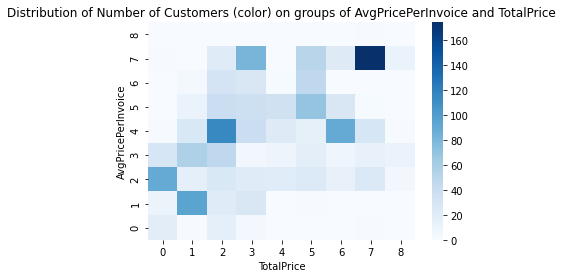

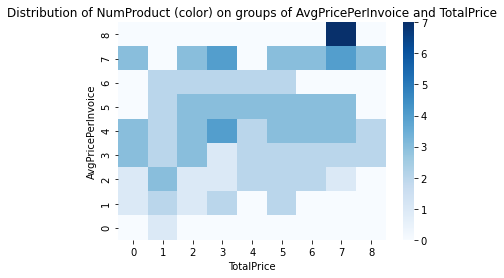

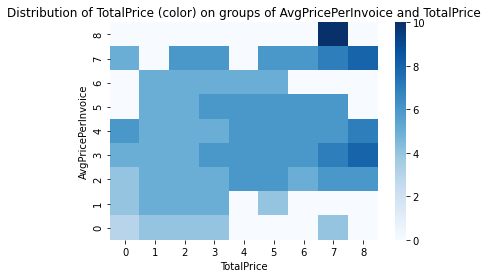

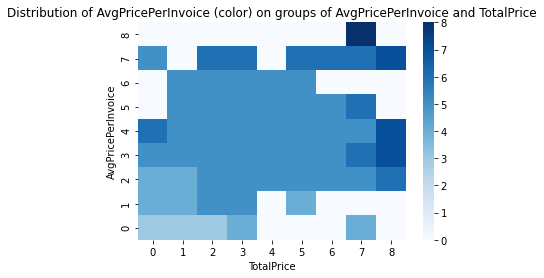

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

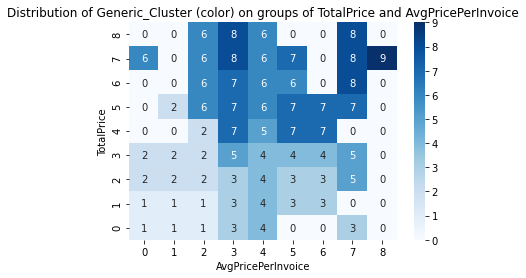

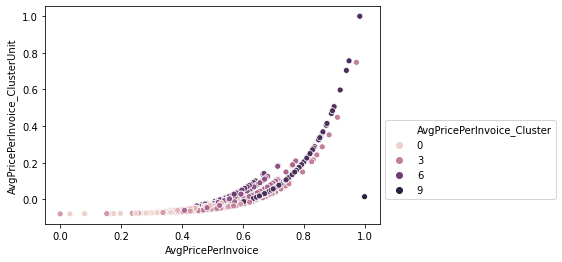

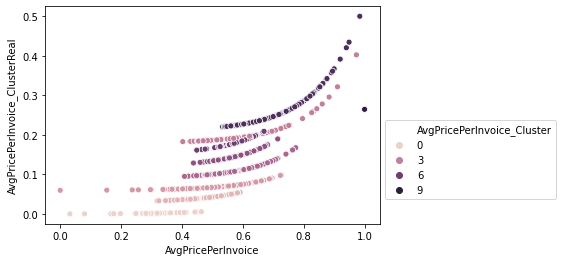

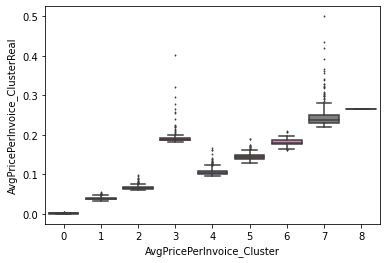

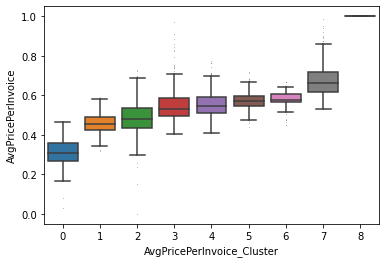

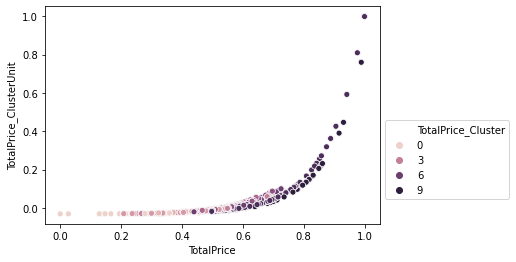

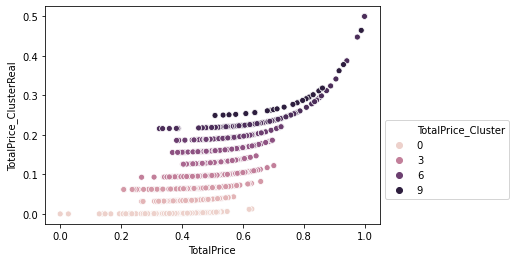

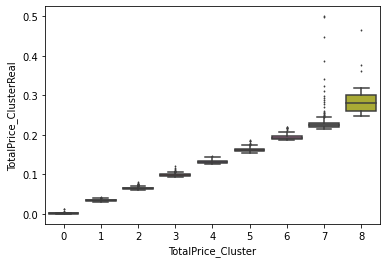

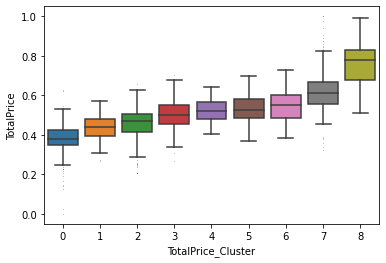

In [ ]:
_tmp_visualize_clusters(cluster_df, cusseg_target)

# Make groups of segments

- Reduce variance to easier observe and inference.

## Manually shifting clusters

- Good

- Just apply for 2 KPIs

In [ ]:
cluster_df_shift = shift_clusters(cluster_df)

### Shifting clusters

- Have the same effect on KPIs
- Find similar segments

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


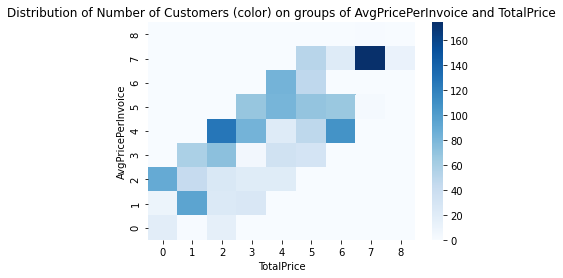

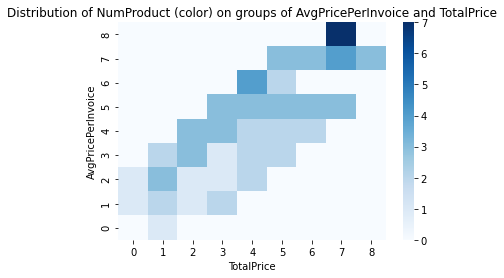

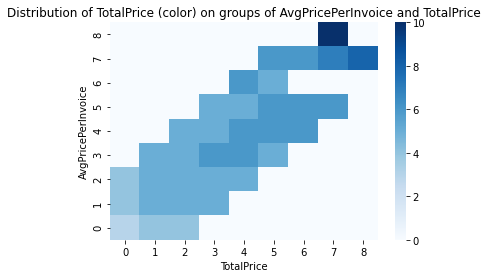

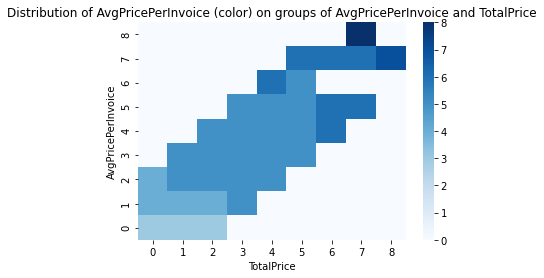

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

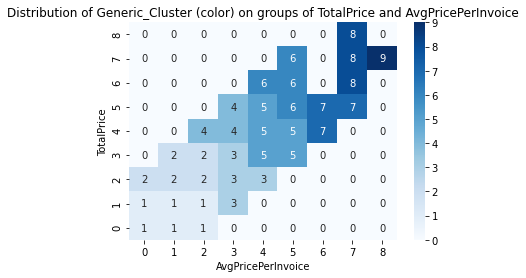

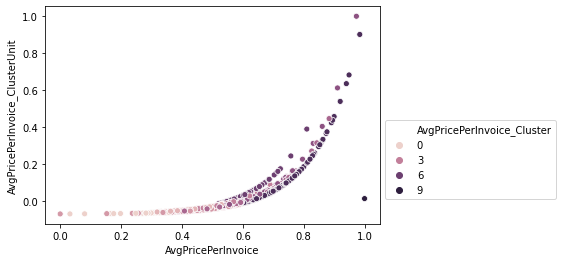

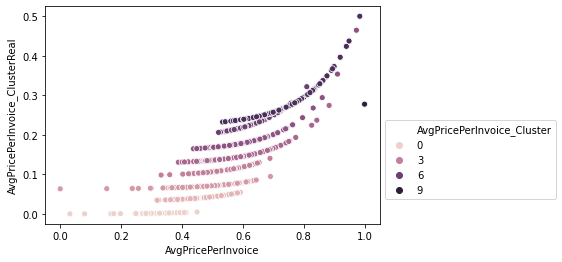

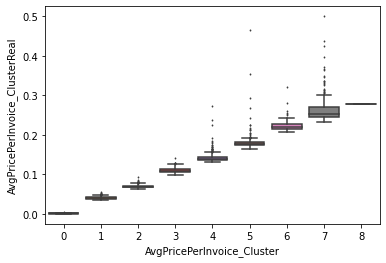

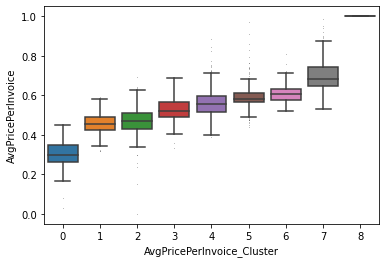

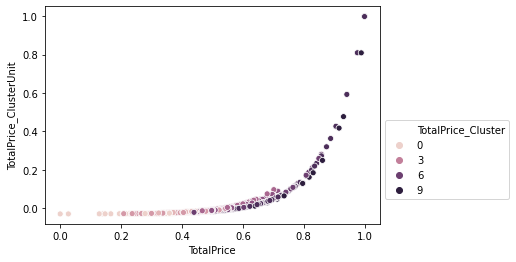

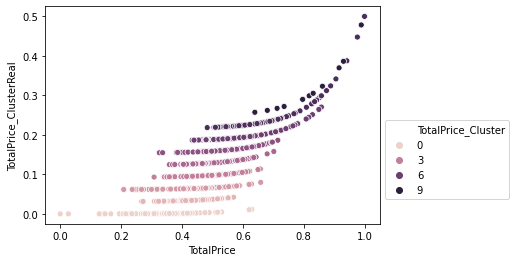

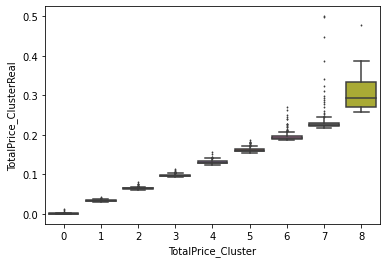

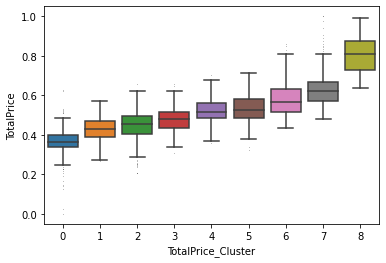

In [ ]:
_tmp_visualize_clusters(cluster_df_shift, cusseg_target)

### Relationship between shifting clusters and original clusters

In [ ]:
cluster_df_shift[['TotalPrice_shift', 'AvgPricePerInvoice_shift']] = cluster_df_shift[['TotalPrice_Cluster', 'AvgPricePerInvoice_Cluster']]
cluster_df_shift[['TotalPrice_Cluster_origin', 'AvgPricePerInvoice_Cluster_origin', 'TotalPrice', 'AvgPricePerInvoice']] = cluster_df[['TotalPrice_Cluster', 'AvgPricePerInvoice_Cluster', 'TotalPrice', 'AvgPricePerInvoice']]
cluster_df_shift.head()

CustomerID  AvgPricePerInvoice_Cluster  TotalPrice_Cluster  \
0       17733                           5                   6   
1       17419                           5                   5   
2       13461                           4                   6   
3       13697                           3                   4   
4       14911                           7                   7   

   Generic_Cluster  NumProduct  TotalPrice  AvgPricePerInvoice  \
0                6          23      475.24          475.240000   
1                6          53     1101.02          367.006667   
2                5          10      560.80          560.800000   
3                5          12      151.30          151.300000   
4                8         918    22720.73          668.256765   

   TotalPrice_shift  AvgPricePerInvoice_shift  TotalPrice_Cluster_origin  \
0                 6                         5                          6   
1                 5                         5                          5   
2                 6                         4                          6   
3                 4                         3                          5   
4                 7                         7                          7   

   AvgPricePerInvoice_Cluster_origin  
0                                  5  
1                                  5  
2                                  4  
3                                  2  
4                                  7

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                   119.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                   198.0  0.0  1.0  0.853535  1.0  1.0  1.0
2                   267.0  1.0  2.0  1.872659  2.0  2.0  3.0
3                   204.0  0.0  2.0  2.602941  3.0  3.0  3.0
4                   242.0  2.0  3.0  3.495868  3.0  4.0  7.0
5                   247.0  5.0  5.0  5.287449  5.0  5.0  7.0
6                   197.0  6.0  6.0  6.375635  6.0  7.0  8.0
7                   178.0  7.0  7.0  7.005618  7.0  7.0  8.0
8                    12.0  8.0  8.0  8.000000  8.0  8.0  8.0
                            count  min  25%      mean  50%  75%  max
AvgPricePerInvoice_Cluster                                          
0                            36.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                           157.0  0.0  1.0  0.974522  1.0  1.0  1.0
2                           202.0  1.0  2.0  2.133663

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


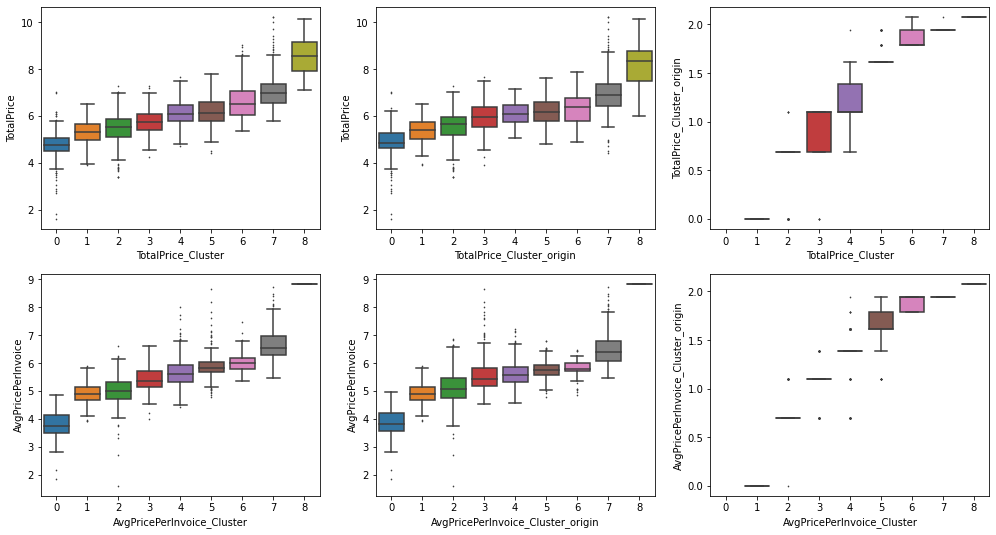

In [ ]:
_compare_clusterways(cluster_df_shift, name2='Cluster_origin',name1='Cluster')

## Grouping by percentiles

- Not good for Custom Segment if you directly

- Could be automatic for more than 2 KPIs

In [ ]:
cluster_df[['TotalPrice_Group', 'AvgPricePerInvoice_Group']] = get_groupdata(cluster_df, ['TotalPrice', 'AvgPricePerInvoice'], percentiles =  [0.0014, 0.0227, 0.1587, 0.5, 0.8413, 0.9773, 0.9986]) # 50-34.13-13.6-2.13
cluster_df.head()

CustomerID  AvgPricePerInvoice_Cluster  TotalPrice_Cluster  \
0       17733                           5                   6   
1       17419                           5                   5   
2       13461                           4                   6   
3       13697                           2                   5   
4       14911                           7                   7   

   Generic_Cluster  NumProduct  TotalPrice  AvgPricePerInvoice  \
0                6          23      475.24          475.240000   
1                6          53     1101.02          367.006667   
2                5          10      560.80          560.800000   
3                5          12      151.30          151.300000   
4                8         918    22720.73          668.256765   

   TotalPrice_Group  AvgPricePerInvoice_Group  
0                 4                         4  
1                 5                         4  
2                 4                         4  
3                 2                         3  
4                 6                         5

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


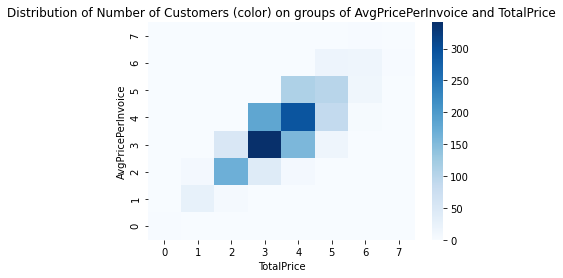

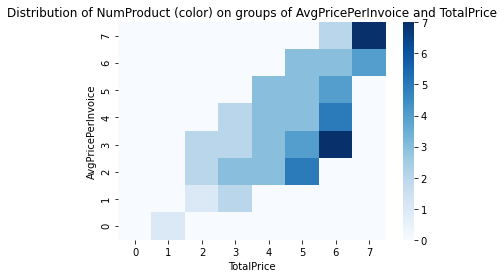

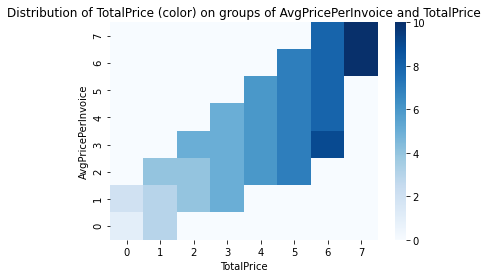

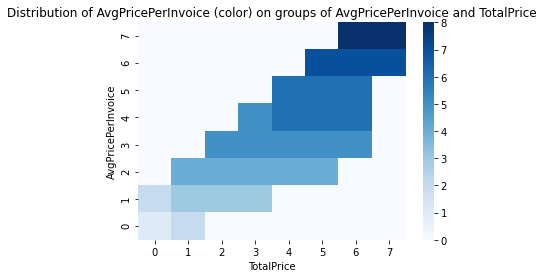

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

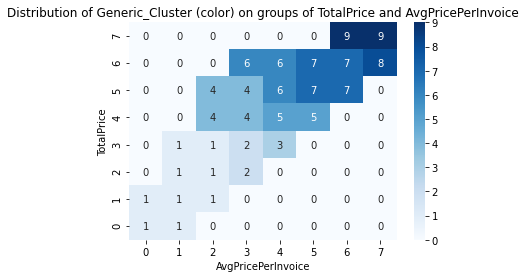

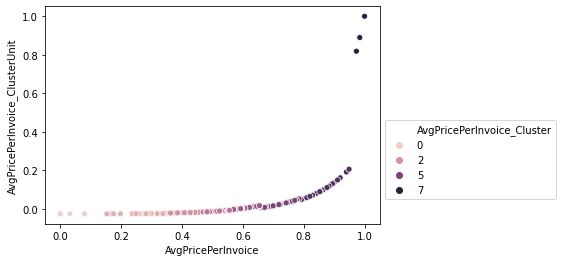

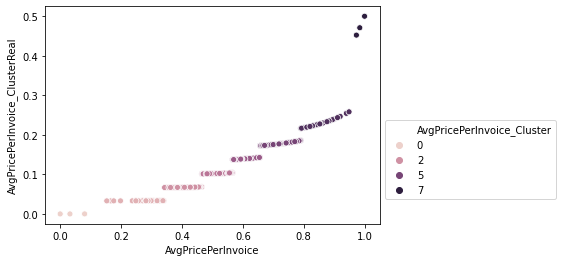

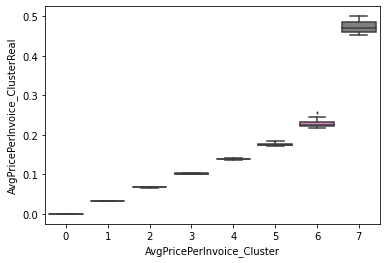

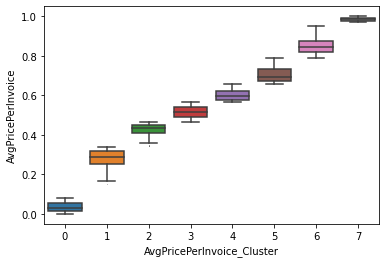

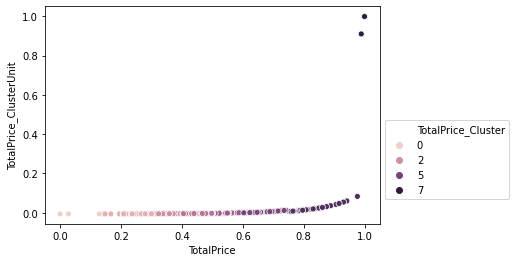

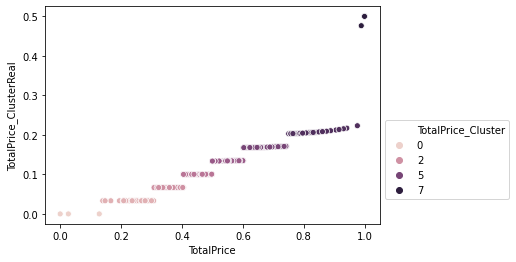

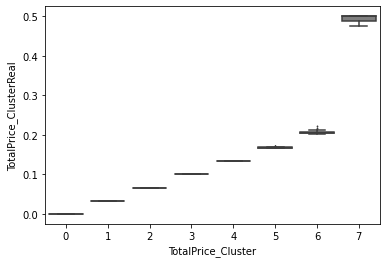

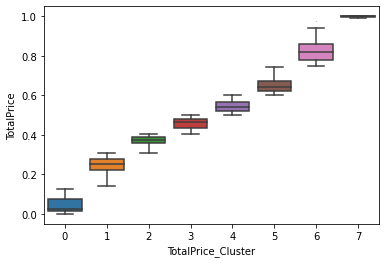

In [ ]:
_tmp_visualize_clusters(cluster_df.drop(['TotalPrice_Cluster', 'AvgPricePerInvoice_Cluster'], axis=1).rename(columns={'TotalPrice_Group':'TotalPrice_Cluster', 'AvgPricePerInvoice_Group':'AvgPricePerInvoice_Cluster'}), cusseg_target)

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                   149.0  0.0  2.0  2.275168  2.0  3.0  5.0
1                   211.0  1.0  2.0  2.829384  3.0  3.0  4.0
2                   316.0  1.0  3.0  3.060127  3.0  4.0  5.0
3                   241.0  1.0  3.0  3.481328  4.0  4.0  5.0
4                    87.0  2.0  3.0  3.655172  4.0  4.0  5.0
5                   226.0  2.0  3.0  3.818584  4.0  4.0  5.0
6                   160.0  2.0  3.0  3.918750  4.0  4.0  5.0
7                   245.0  2.0  4.0  4.551020  5.0  5.0  7.0
8                    29.0  4.0  5.0  5.482759  6.0  6.0  7.0
                            count  min  25%      mean  50%  75%  max
AvgPricePerInvoice_Cluster                                          
0                            41.0  0.0  1.0  1.268293  1.0  2.0  2.0
1                           154.0  1.0  2.0  2.480519  2.0  3.0  4.0
2                           240.0  0.0  2.0  2.795833

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


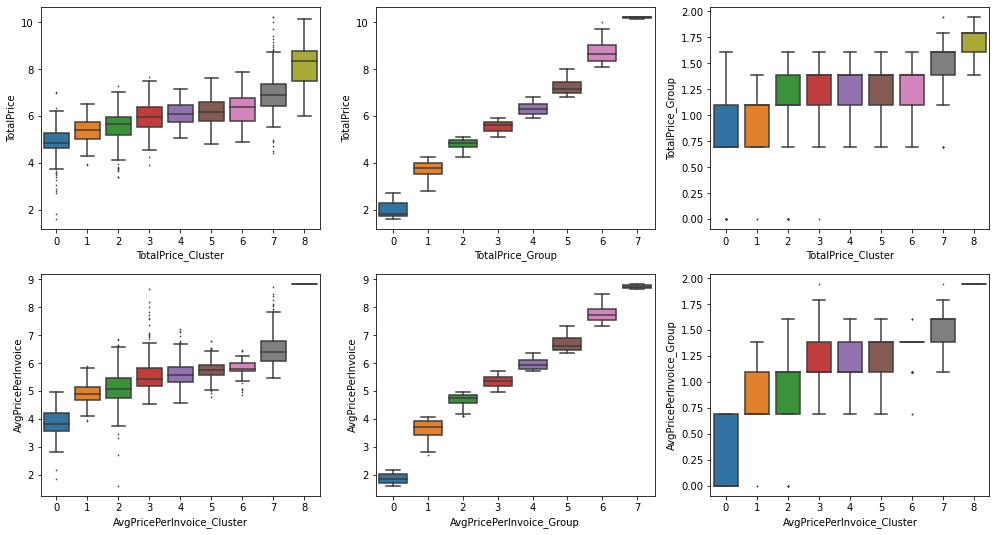

In [ ]:
_compare_clusterways(cluster_df, name2='Group',name1='Cluster')

## Hybrid between original custom and groups of KPIs

Remind the goal: to simplify (or to make groups of) segments, then easier to compare with further results or results of other regressors.

In [ ]:
def shift_labels(labels):
	map_labels = dict(zip(sorted(labels.unique()), range(labels.nunique())))
	new_labels = labels.apply(lambda r: map_labels[r])
	return new_labels

In [ ]:
z_func = lambda x, y: (x + y)

In [ ]:
def test_hybrid(cluster_df):
    cluster_df_new = pd.DataFrame()
    cluster_df_new[['TotalPrice', 'TotalPrice_Cluster_origin', 'TotalPrice_Group', 'AvgPricePerInvoice', 'AvgPricePerInvoice_Cluster_origin', 'AvgPricePerInvoice_Group', 'Generic_Cluster']] = \
            cluster_df[['TotalPrice', 'TotalPrice_Cluster', 'TotalPrice_Group', 'AvgPricePerInvoice', 'AvgPricePerInvoice_Cluster', 'AvgPricePerInvoice_Group', 'Generic_Cluster']]
    for target in cusseg_target:
        cluster_df_new['%s_Cluster'%target] = shift_labels(z_func(cluster_df_new['%s_Cluster_origin'%target], cluster_df_new['%s_Group'%target]))
        get_clustersorted(cluster_df_new, cluster_name = '%s_Cluster'%target, valuesorted_name = target, sort_metric='median')
    _compare_clusterways(cluster_df_new, name2='Cluster_origin',name1='Cluster')
    _tmp_visualize_clusters(cluster_df_new, cusseg_target)

### Try unscale weights

Results: create many segments with too details, while the main pattern is remained. It's difficult to evaluate which detail segmentation weights are good.

                    count  min  25%      mean  50%   75%  max
TotalPrice_Cluster                                           
0                     3.0  0.0  0.0  0.000000  0.0  0.00  0.0
1                    19.0  0.0  0.0  0.000000  0.0  0.00  0.0
2                    78.0  0.0  0.0  0.025641  0.0  0.00  1.0
3                   108.0  0.0  0.0  0.768519  1.0  1.00  2.0
4                   190.0  0.0  1.0  1.221053  1.0  2.00  3.0
5                   216.0  0.0  2.0  1.986111  2.0  2.00  3.0
6                   170.0  2.0  2.0  2.523529  3.0  3.00  4.0
7                   156.0  2.0  3.0  3.243590  3.0  3.25  5.0
8                   135.0  3.0  4.0  4.414815  5.0  5.00  6.0
9                   171.0  4.0  5.0  5.304094  5.0  6.00  7.0
10                  120.0  5.0  5.0  5.750000  6.0  6.00  7.0
11                  137.0  6.0  6.0  6.722628  7.0  7.00  7.0
12                  115.0  7.0  7.0  7.034783  7.0  7.00  8.0
13                   27.0  7.0  7.0  7.296296  7.0  8.00  8.0
14      

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.

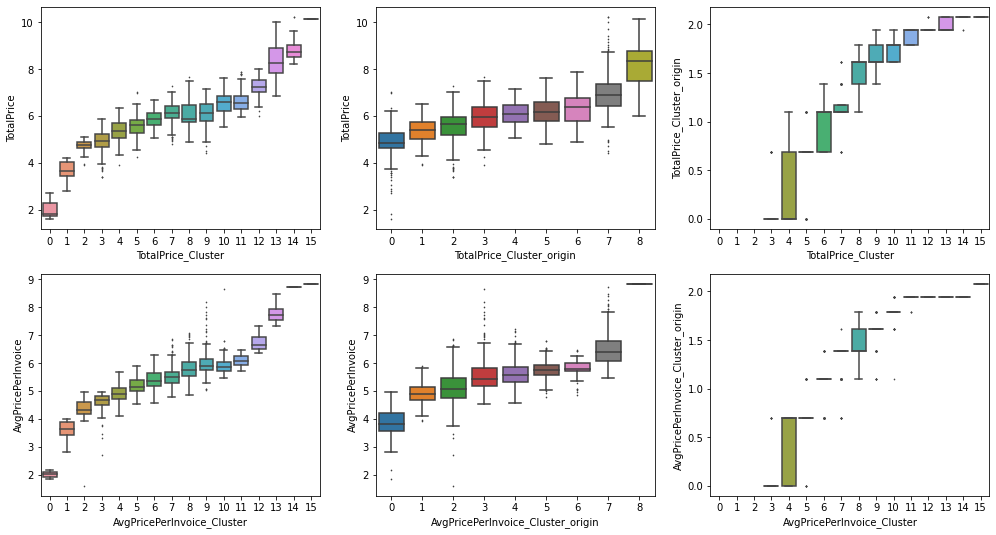

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


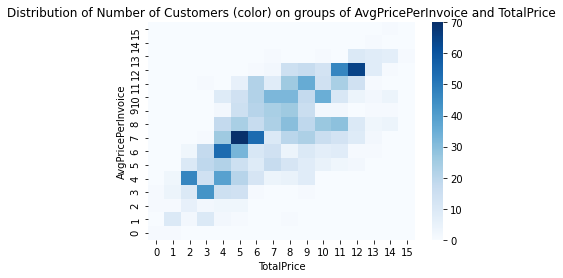

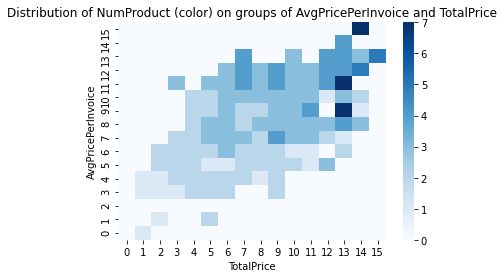

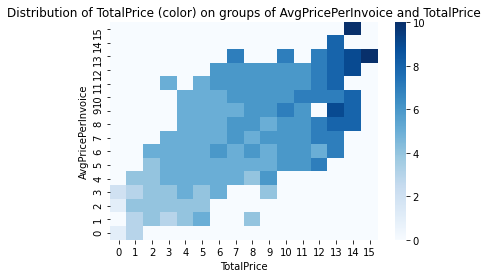

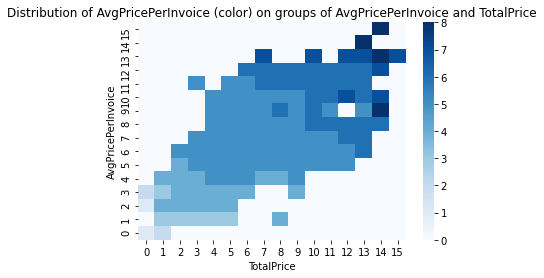

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

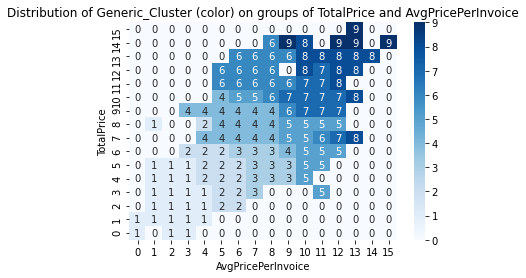

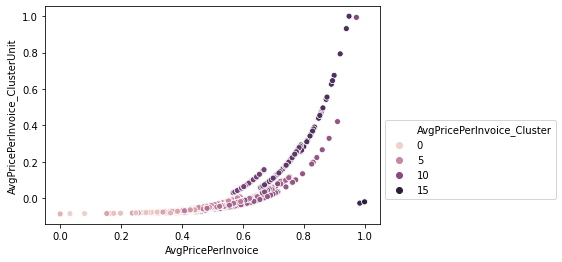

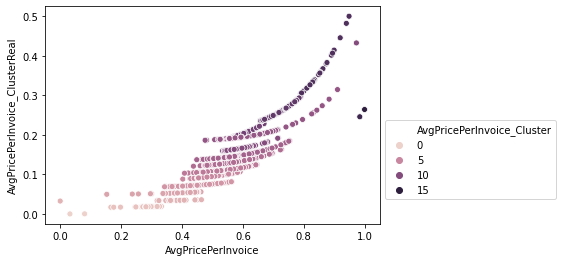

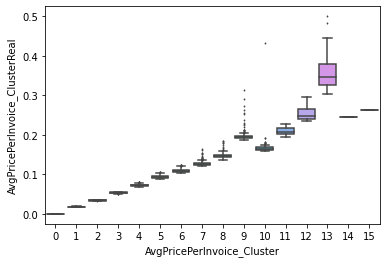

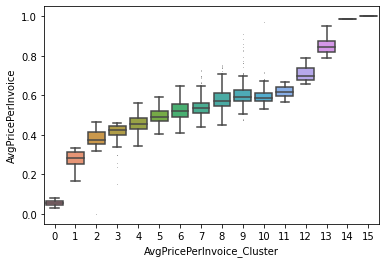

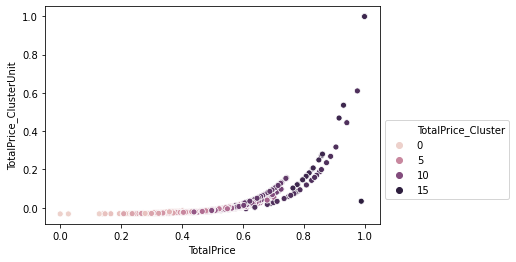

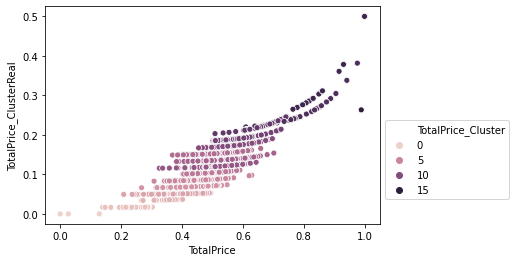

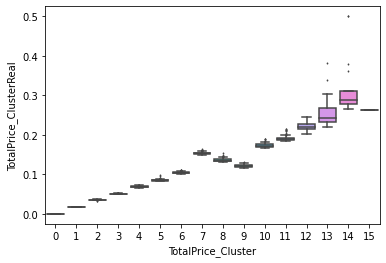

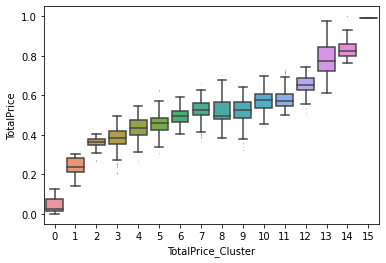

In [ ]:
z_func = lambda x, y: (x+y) #origin + new
test_hybrid(cluster_df)

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                     3.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                    19.0  0.0  0.0  0.000000  0.0  0.0  0.0
2                     2.0  1.0  1.0  1.000000  1.0  1.0  1.0
3                    89.0  0.0  0.0  0.292135  0.0  0.0  2.0
4                    58.0  1.0  1.0  1.034483  1.0  1.0  3.0
5                    89.0  0.0  0.0  1.146067  2.0  2.0  2.0
6                   153.0  1.0  1.0  1.339869  1.0  1.0  3.0
7                   175.0  0.0  2.0  1.885714  2.0  2.0  4.0
8                   118.0  1.0  3.0  2.677966  3.0  3.0  5.0
9                   120.0  0.0  2.0  2.616667  2.0  4.0  6.0
10                  183.0  3.0  3.0  3.863388  3.0  5.0  7.0
11                  100.0  2.0  4.0  4.760000  4.0  6.0  6.0
12                  140.0  3.0  5.0  4.871429  5.0  5.0  7.0
13                   79.0  4.0  6.0  5.873418  6.0  6.0  6.0
14                  137.

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.

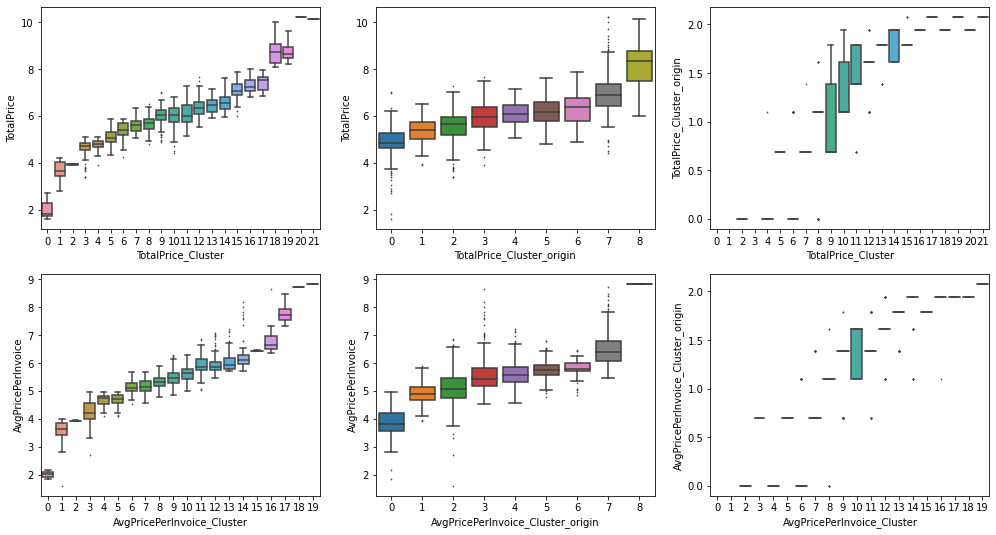

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


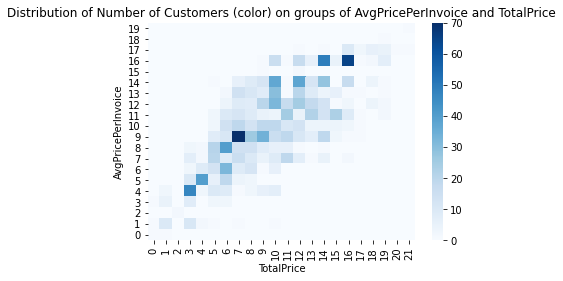

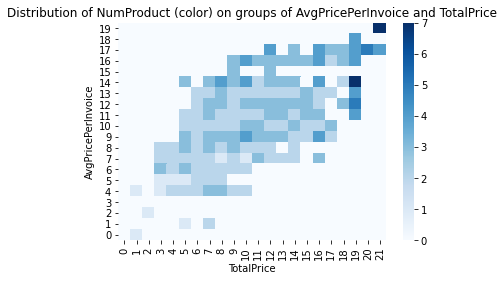

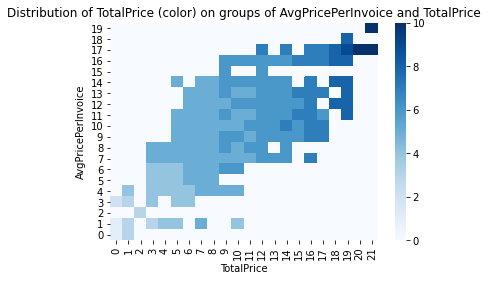

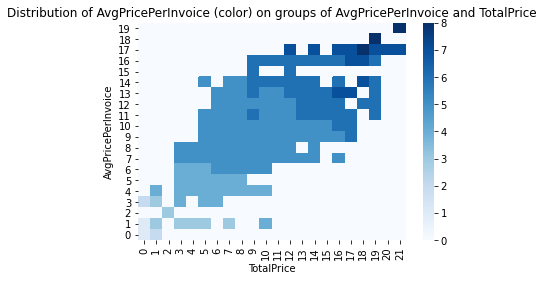

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

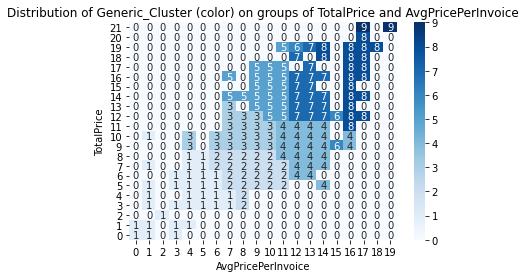

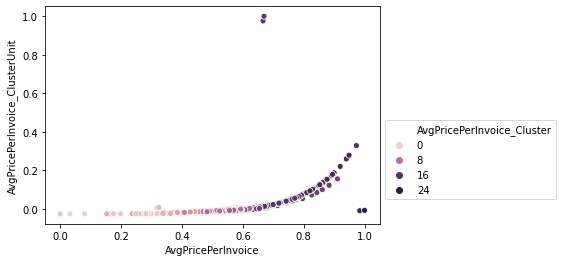

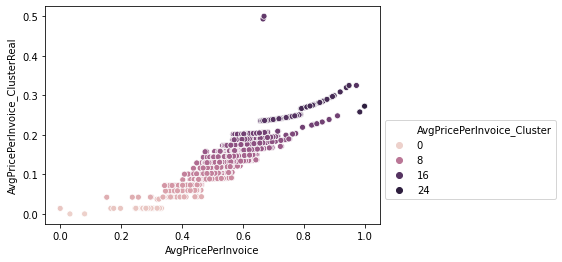

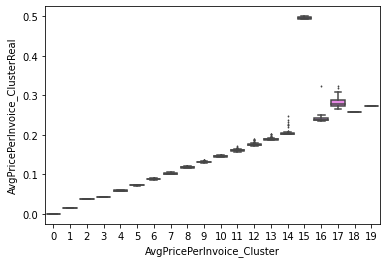

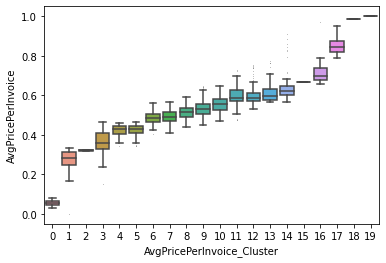

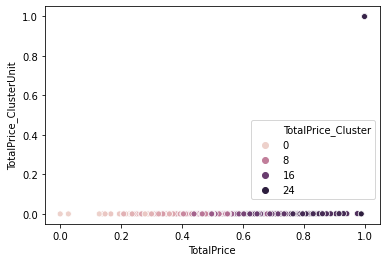

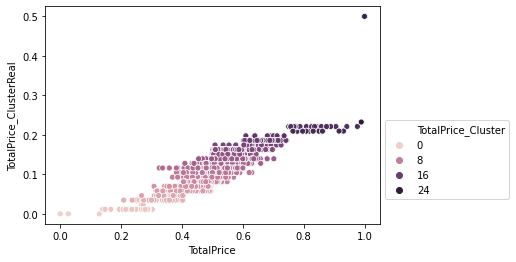

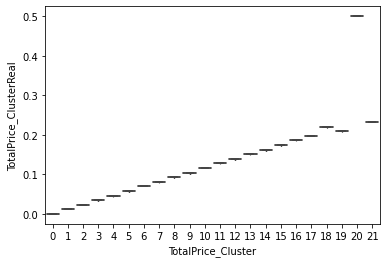

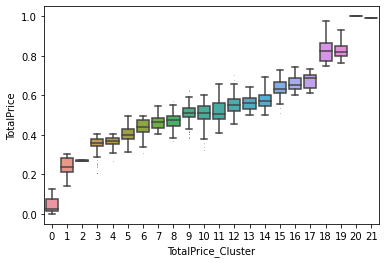

In [ ]:
z_func = lambda x, y: (x+y*2) #origin * 2 + new
test_hybrid(cluster_df)

                    count  min   25%      mean  50%  75%  max
TotalPrice_Cluster                                           
0                     3.0  0.0  0.00  0.000000  0.0  0.0  0.0
1                    19.0  0.0  0.00  0.000000  0.0  0.0  0.0
2                    76.0  0.0  0.00  0.000000  0.0  0.0  0.0
3                    38.0  0.0  0.00  0.000000  0.0  0.0  0.0
4                    13.0  0.0  0.00  0.153846  0.0  0.0  1.0
5                    59.0  0.0  1.00  0.966102  1.0  1.0  1.0
6                   127.0  1.0  1.00  1.000000  1.0  1.0  1.0
7                    38.0  1.0  1.00  1.342105  1.0  2.0  2.0
8                    51.0  2.0  2.00  2.000000  2.0  2.0  2.0
9                   163.0  2.0  2.00  2.000000  2.0  2.0  2.0
10                   83.0  2.0  2.00  2.012048  2.0  2.0  3.0
11                   33.0  2.0  3.00  2.787879  3.0  3.0  3.0
12                   87.0  3.0  3.00  3.000000  3.0  3.0  3.0
13                  110.0  3.0  3.00  3.000000  3.0  3.0  3.0
14      

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.

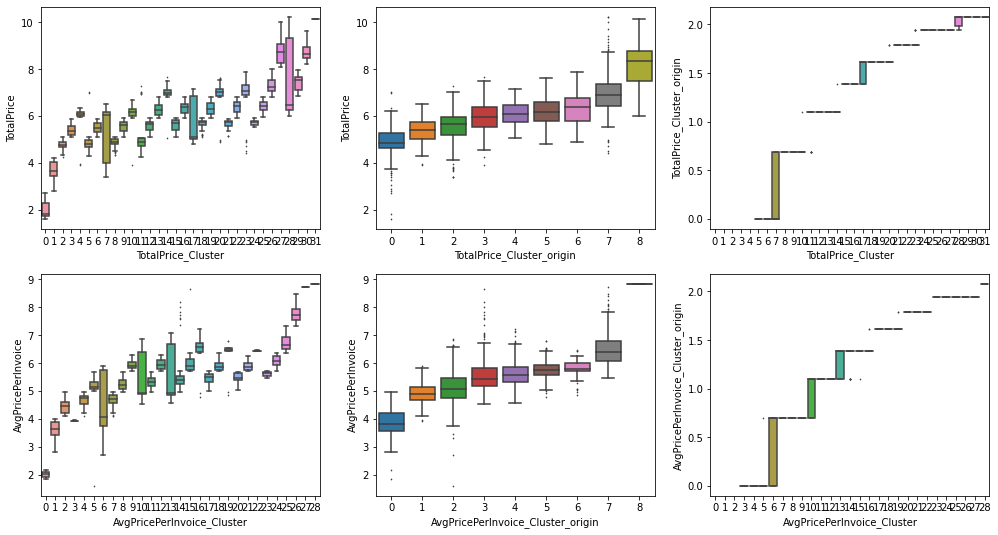

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


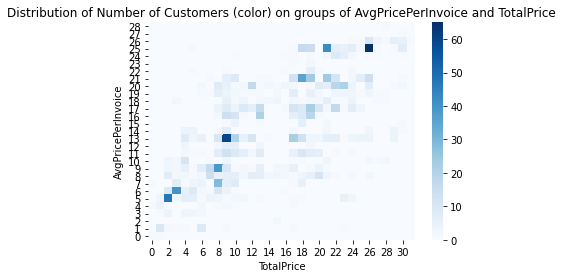

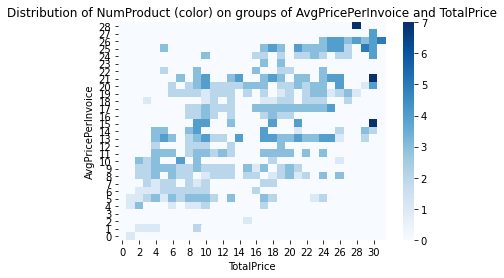

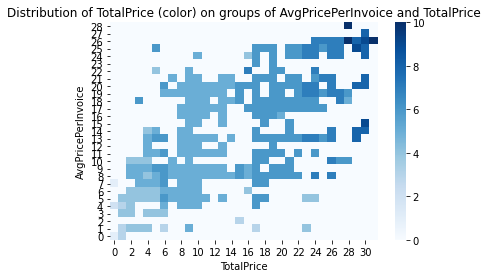

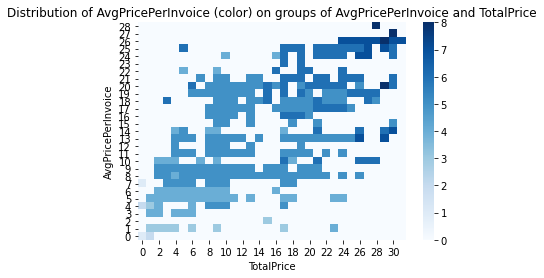

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

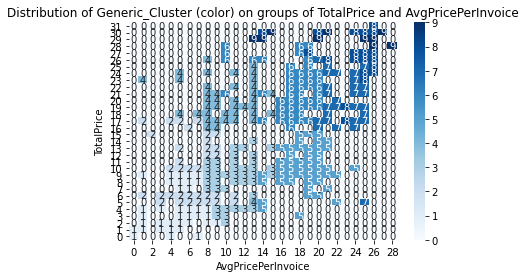

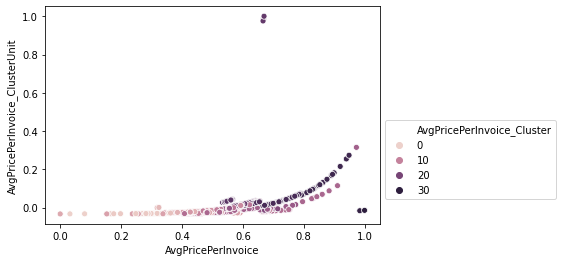

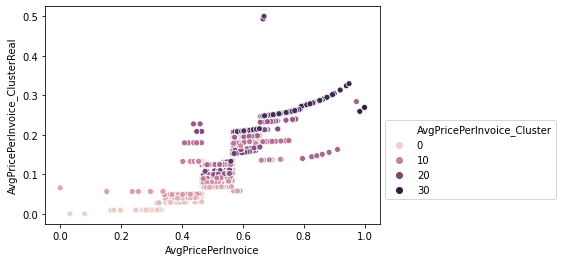

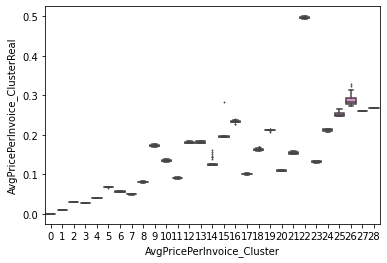

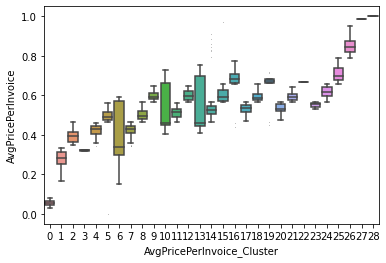

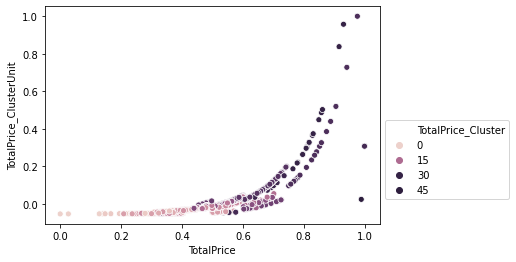

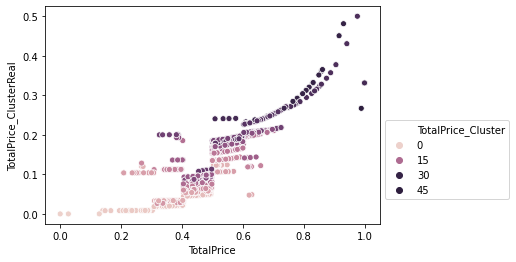

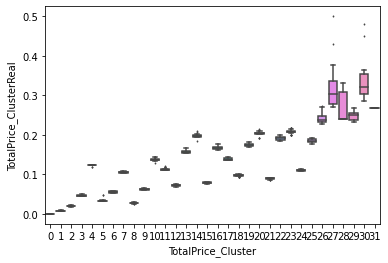

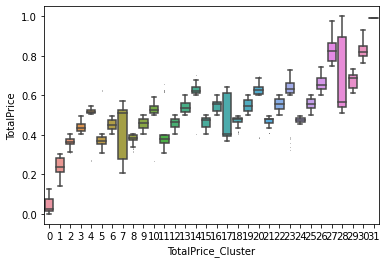

In [ ]:
z_func = lambda x, y: (x*3+y*1) #origin + new
test_hybrid(cluster_df)

### Scaled weights

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                    24.0  0.0  0.0  0.083333  0.0  0.0  1.0
1                   312.0  0.0  0.0  0.682692  1.0  1.0  3.0
2                   365.0  0.0  2.0  2.169863  2.0  3.0  3.0
3                   323.0  2.0  2.0  3.281734  3.0  4.0  5.0
4                   268.0  4.0  5.0  5.085821  5.0  5.0  7.0
5                   322.0  6.0  6.0  6.652174  7.0  7.0  7.0
6                    33.0  7.0  7.0  7.363636  7.0  8.0  8.0
7                    17.0  8.0  8.0  8.000000  8.0  8.0  8.0
                            count  min  25%      mean  50%  75%  max
AvgPricePerInvoice_Cluster                                          
0                            30.0  0.0  0.0  0.066667  0.0  0.0  1.0
1                           167.0  0.0  1.0  0.970060  1.0  1.0  2.0
2                           319.0  1.0  2.0  2.385580  2.0  3.0  3.0
3                           390.0  2.0  3.0  

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


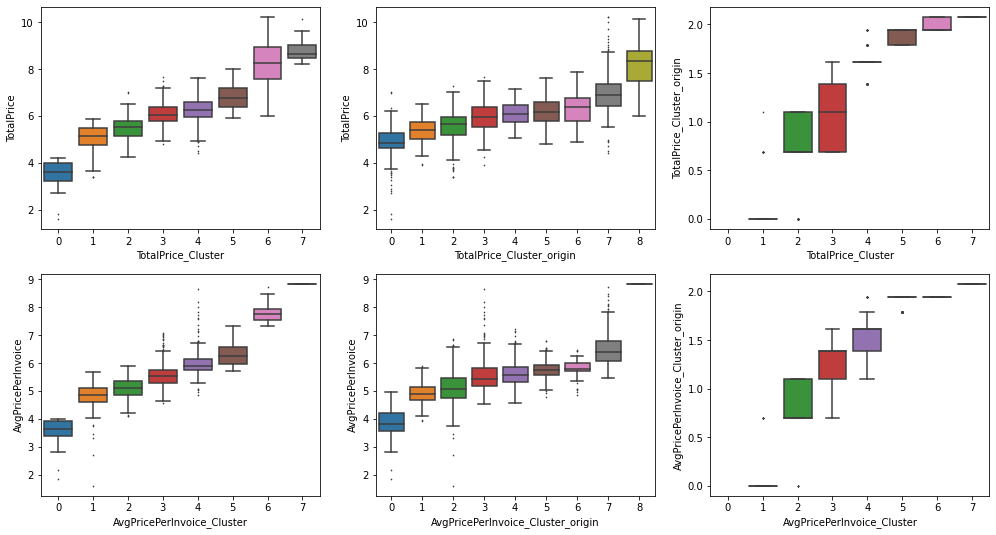

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


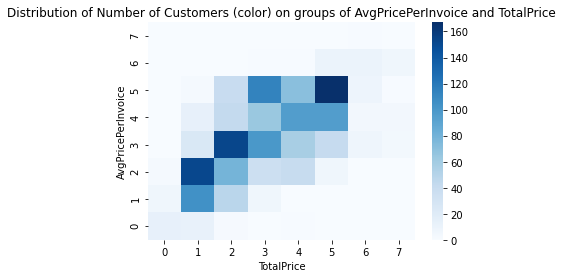

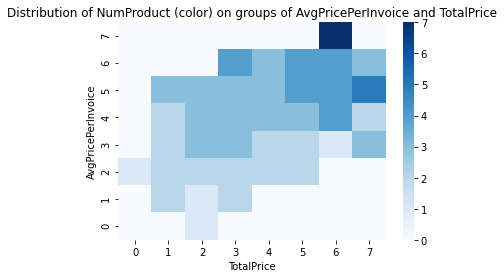

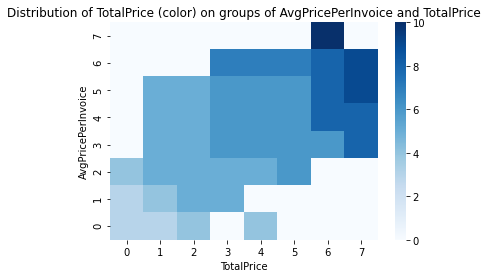

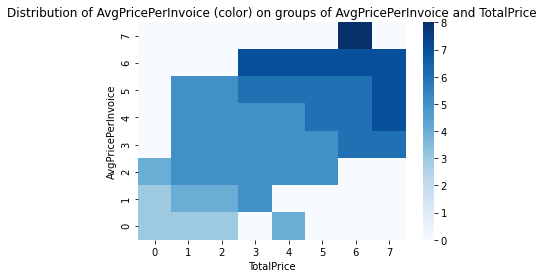

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

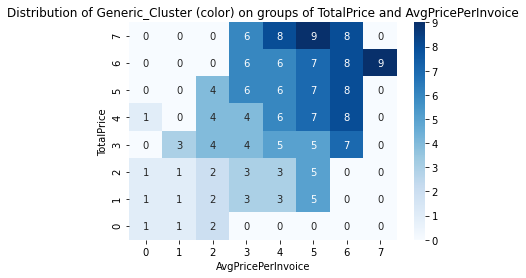

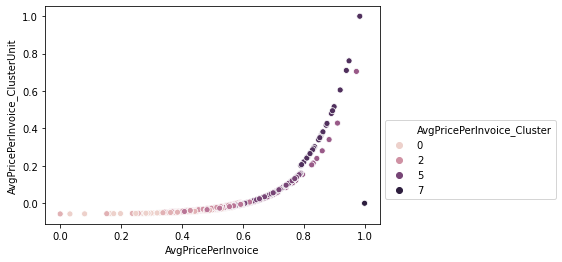

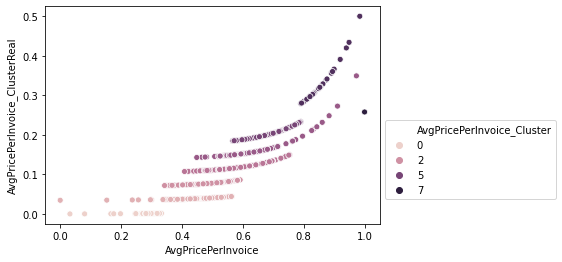

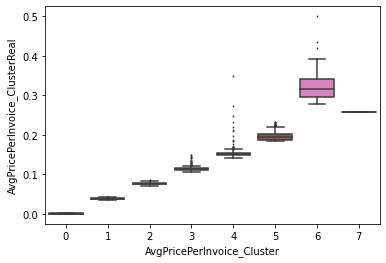

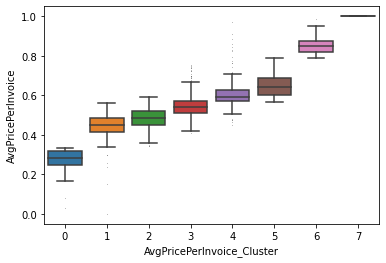

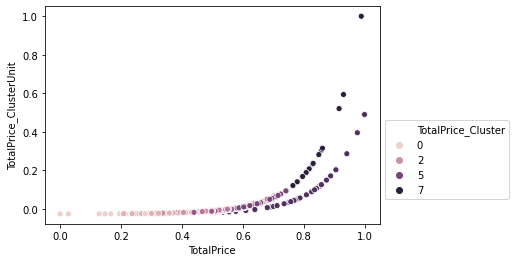

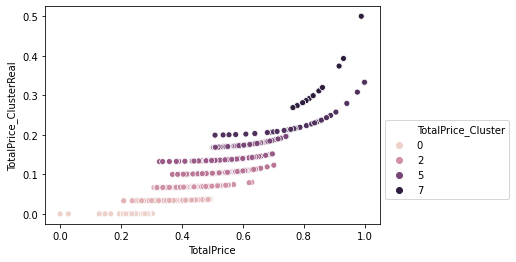

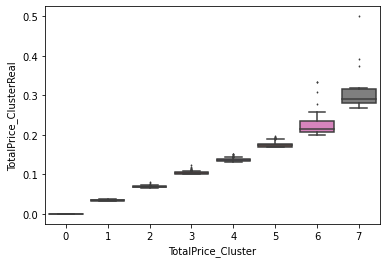

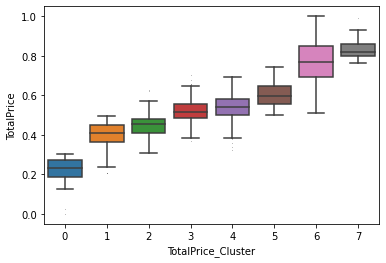

In [ ]:
z_func = lambda x, y: pd.Series(np.array(x*0.5).astype(int)+np.array(y*0.5).astype(int)) #origin + new
test_hybrid(cluster_df)

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                    22.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                   186.0  0.0  0.0  0.456989  0.0  1.0  2.0
2                   406.0  0.0  1.0  1.628079  2.0  2.0  3.0
3                   326.0  2.0  2.0  2.868098  3.0  3.0  5.0
4                   306.0  3.0  5.0  4.911765  5.0  5.0  7.0
5                   257.0  5.0  6.0  6.268482  6.0  7.0  7.0
6                   142.0  7.0  7.0  7.084507  7.0  7.0  8.0
7                    19.0  7.0  8.0  7.894737  8.0  8.0  8.0
                            count  min   25%      mean  50%   75%  max
AvgPricePerInvoice_Cluster                                            
0                            28.0  0.0  0.00  0.000000  0.0  0.00  0.0
1                           105.0  0.0  1.00  0.952381  1.0  1.00  2.0
2                           275.0  1.0  1.00  1.821818  2.0  2.00  3.0
3                           408.0  

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


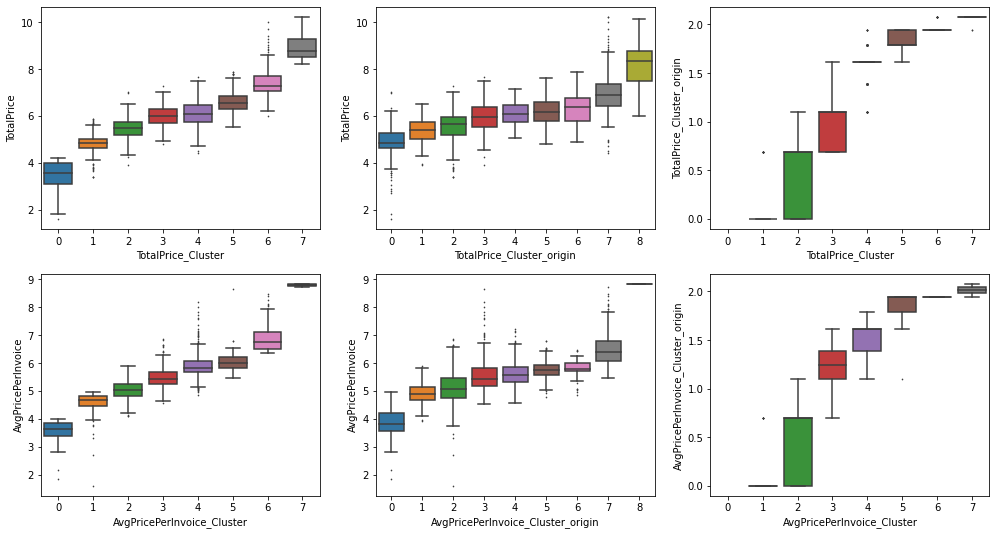

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


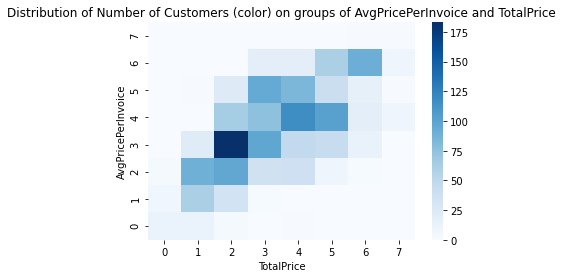

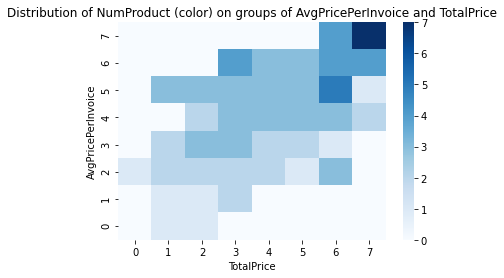

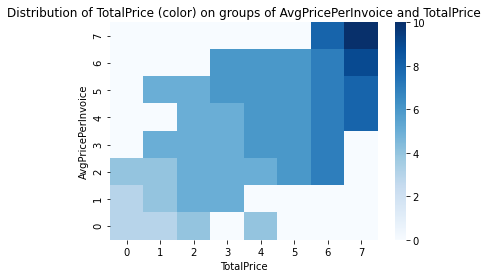

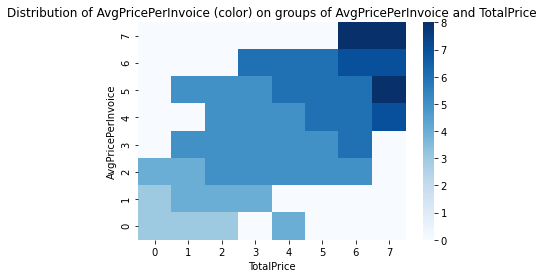

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

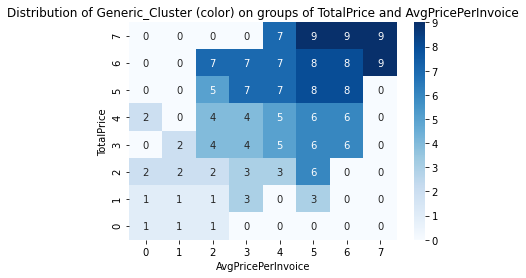

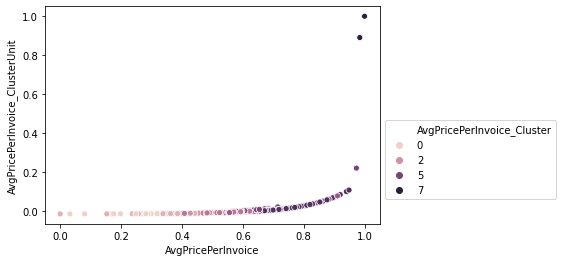

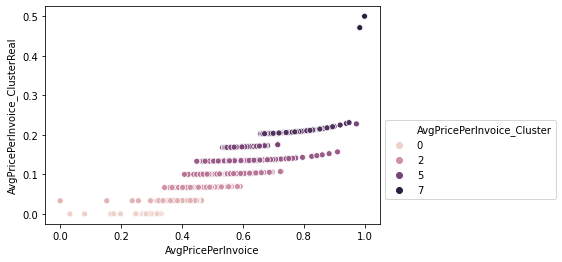

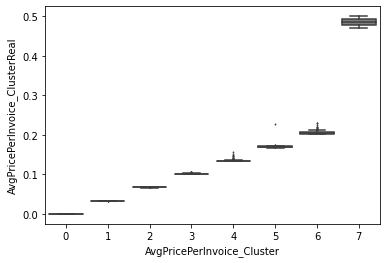

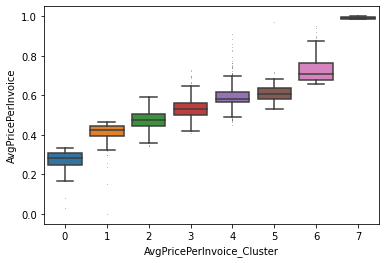

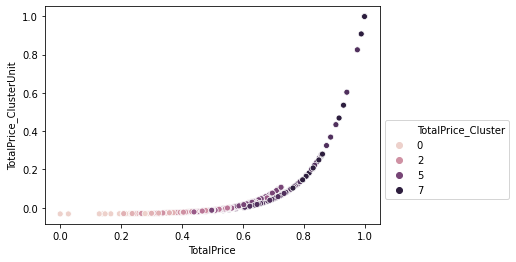

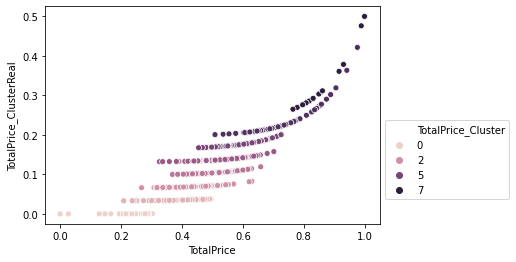

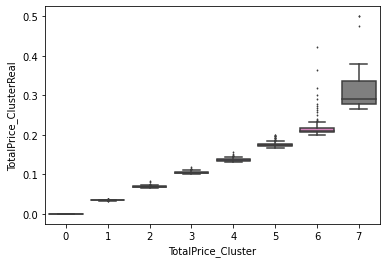

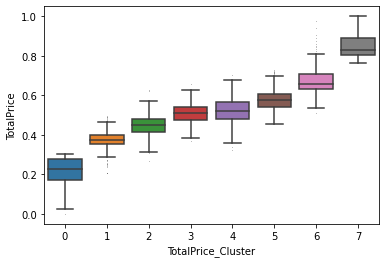

In [ ]:
z_func = lambda x, y: pd.Series(np.array(x*0.5+y*0.5).astype(int)) #origin + new
test_hybrid(cluster_df)

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                   136.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                   237.0  0.0  1.0  1.000000  1.0  1.0  2.0
2                   330.0  2.0  2.0  2.081818  2.0  2.0  3.0
3                   248.0  3.0  3.0  3.137097  3.0  3.0  4.0
4                   241.0  4.0  5.0  4.780083  5.0  5.0  5.0
5                   204.0  5.0  6.0  5.843137  6.0  6.0  7.0
6                   237.0  7.0  7.0  7.000000  7.0  7.0  7.0
7                    31.0  7.0  8.0  7.935484  8.0  8.0  8.0
                            count  min   25%      mean  50%   75%  max
AvgPricePerInvoice_Cluster                                            
0                            41.0  0.0  0.00  0.000000  0.0  0.00  0.0
1                           162.0  1.0  1.00  1.049383  1.0  1.00  2.0
2                           253.0  2.0  2.00  2.083004  2.0  2.00  3.0
3                           376.0  

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


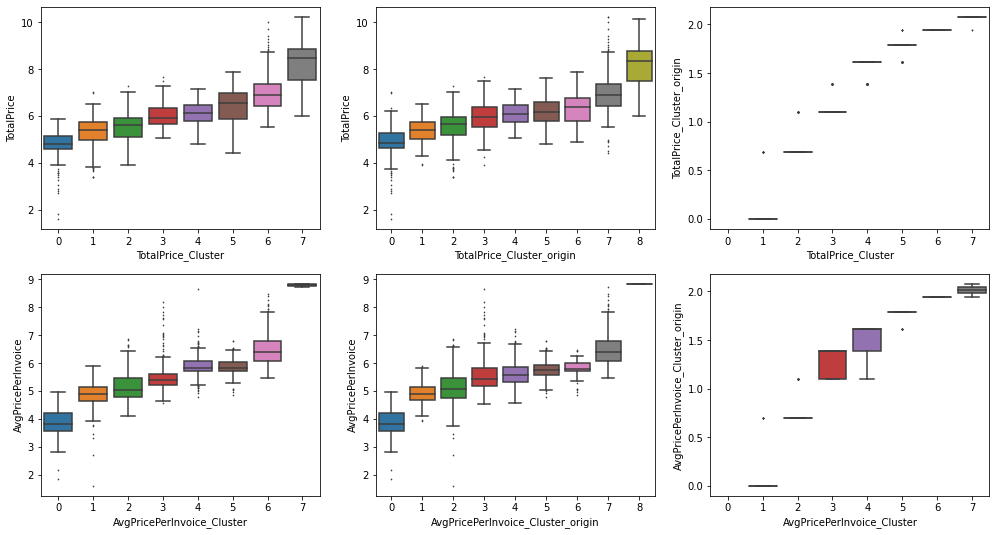

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


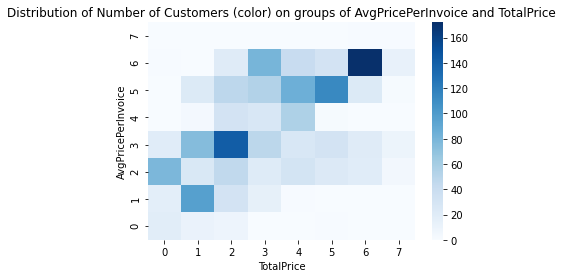

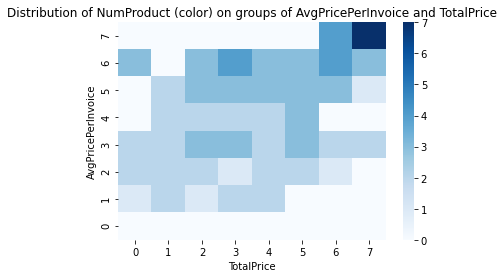

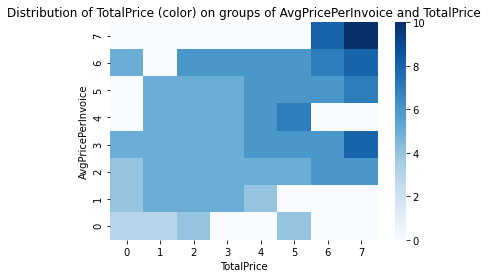

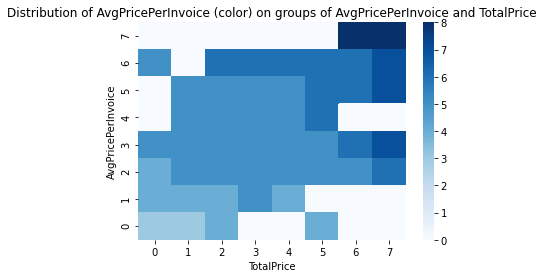

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

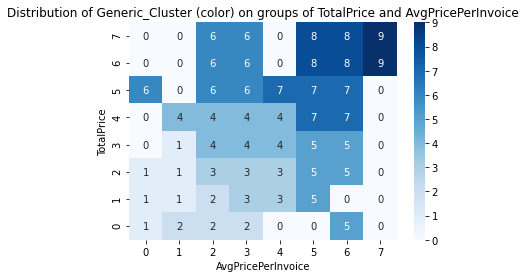

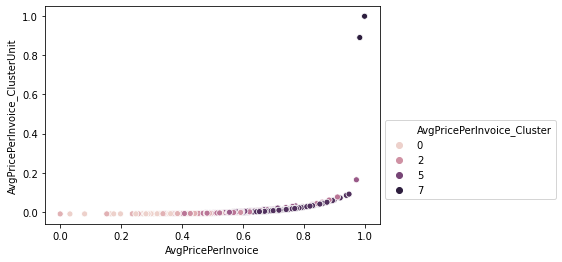

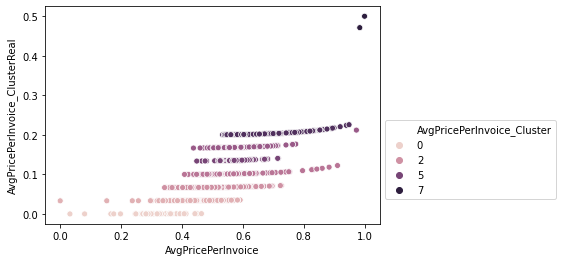

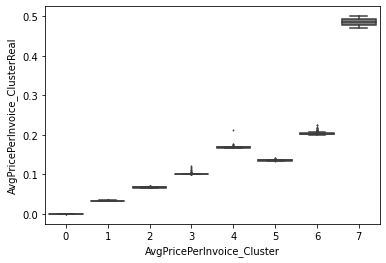

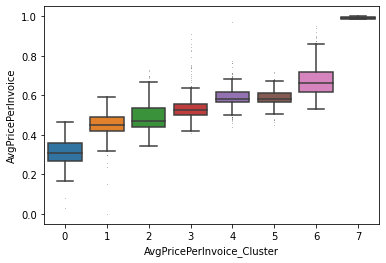

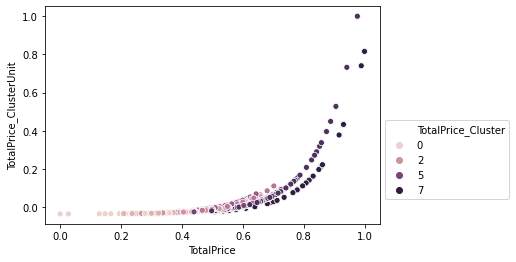

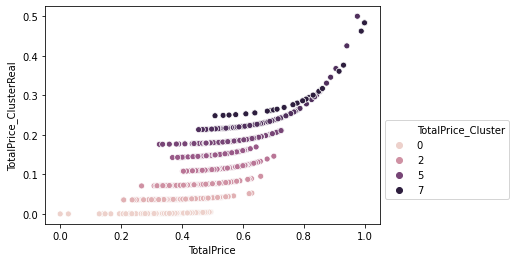

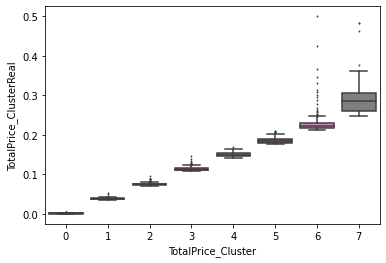

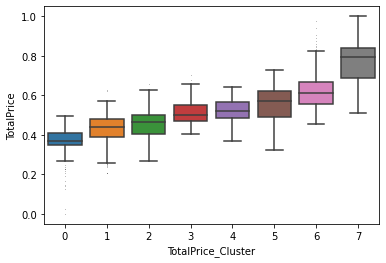

In [ ]:
z_func = lambda x, y: pd.Series(np.array(x*0.75+y*0.25).astype(int)) #origin + new
test_hybrid(cluster_df)

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                    22.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                   149.0  0.0  0.0  0.590604  0.0  1.0  3.0
2                   412.0  0.0  1.0  1.618932  2.0  2.0  5.0
3                   471.0  0.0  2.0  3.348195  3.0  5.0  7.0
4                   373.0  2.0  5.0  5.482574  5.0  7.0  7.0
5                   199.0  5.0  6.0  6.487437  7.0  7.0  8.0
6                    35.0  7.0  7.0  7.457143  7.0  8.0  8.0
7                     3.0  7.0  7.0  7.333333  7.0  7.5  8.0
                            count  min   25%      mean  50%   75%  max
AvgPricePerInvoice_Cluster                                            
0                            29.0  0.0  0.00  0.068966  0.0  0.00  2.0
1                           104.0  0.0  1.00  0.942308  1.0  1.00  2.0
2                           288.0  1.0  2.00  1.989583  2.0  2.00  5.0
3                           489.0  

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


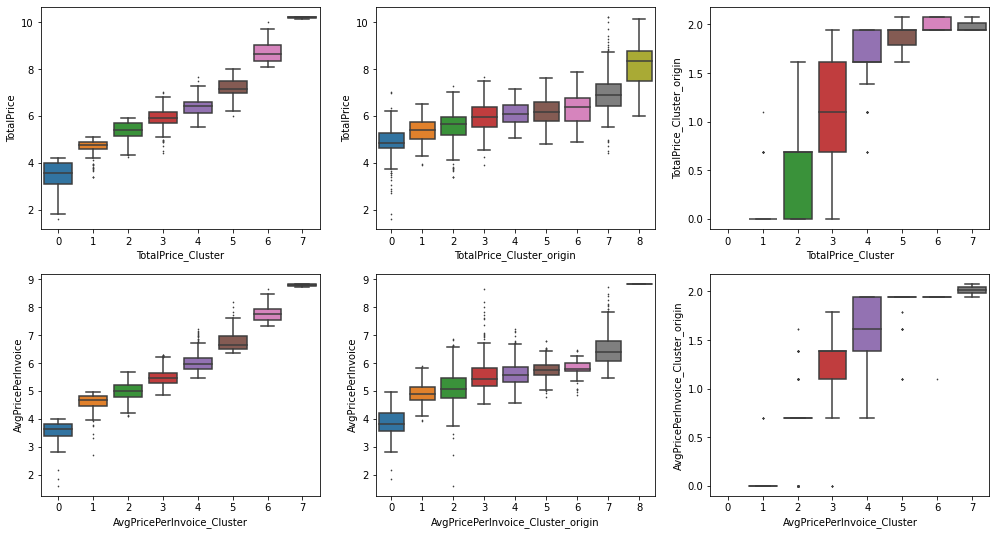

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


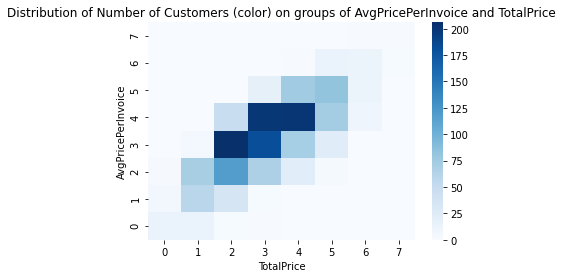

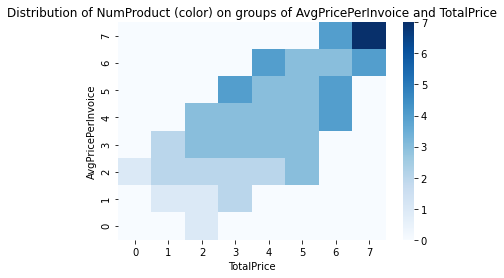

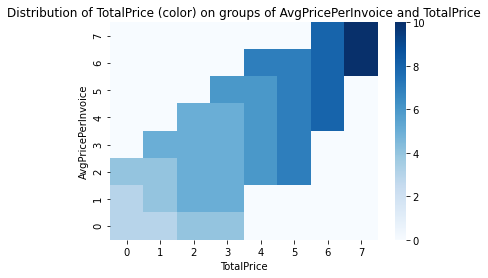

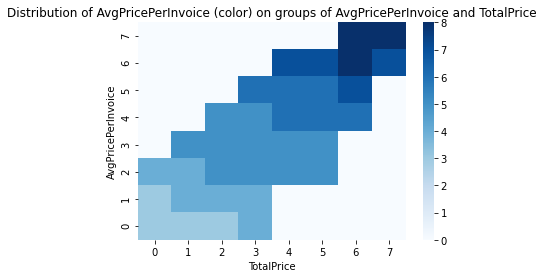

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

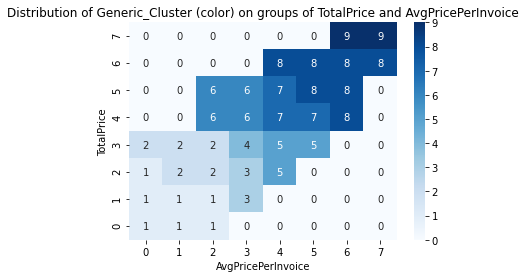

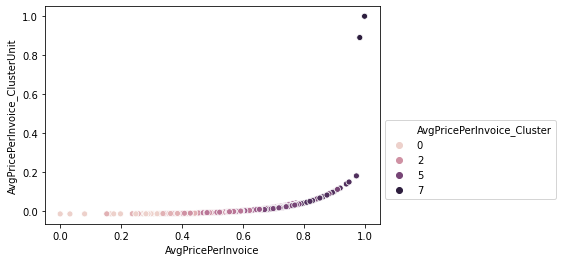

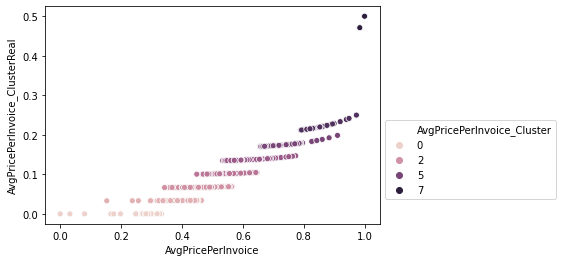

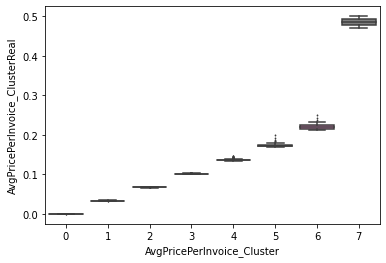

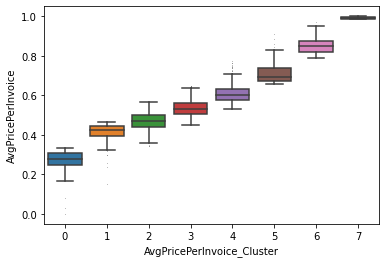

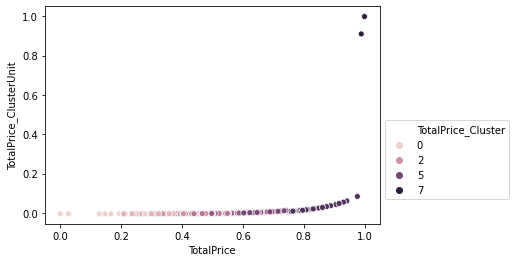

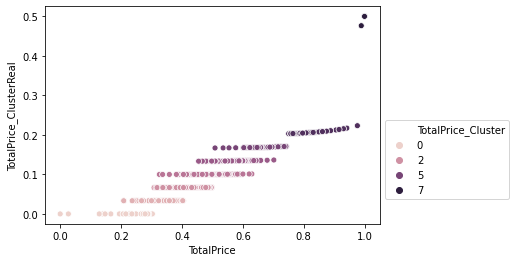

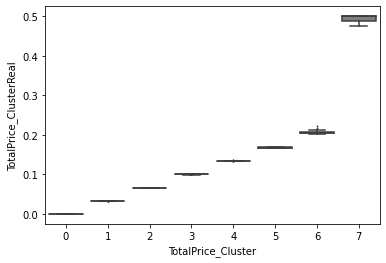

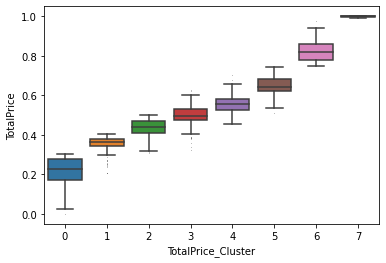

In [ ]:
z_func = lambda x, y: pd.Series(np.array(x*0.25+y*0.75).astype(int)) #origin + new
test_hybrid(cluster_df)

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                   147.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                   226.0  0.0  1.0  1.048673  1.0  1.0  2.0
2                   330.0  2.0  2.0  2.081818  2.0  2.0  3.0
3                   248.0  3.0  3.0  3.137097  3.0  3.0  4.0
4                   241.0  4.0  5.0  4.780083  5.0  5.0  5.0
5                   198.0  5.0  6.0  5.808081  6.0  6.0  6.0
6                   243.0  7.0  7.0  7.000000  7.0  7.0  7.0
7                    31.0  7.0  8.0  7.935484  8.0  8.0  8.0
                            count  min   25%      mean  50%   75%  max
AvgPricePerInvoice_Cluster                                            
0                            41.0  0.0  0.00  0.000000  0.0  0.00  0.0
1                           162.0  1.0  1.00  1.049383  1.0  1.00  2.0
2                           253.0  2.0  2.00  2.083004  2.0  2.00  3.0
3                           377.0  

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


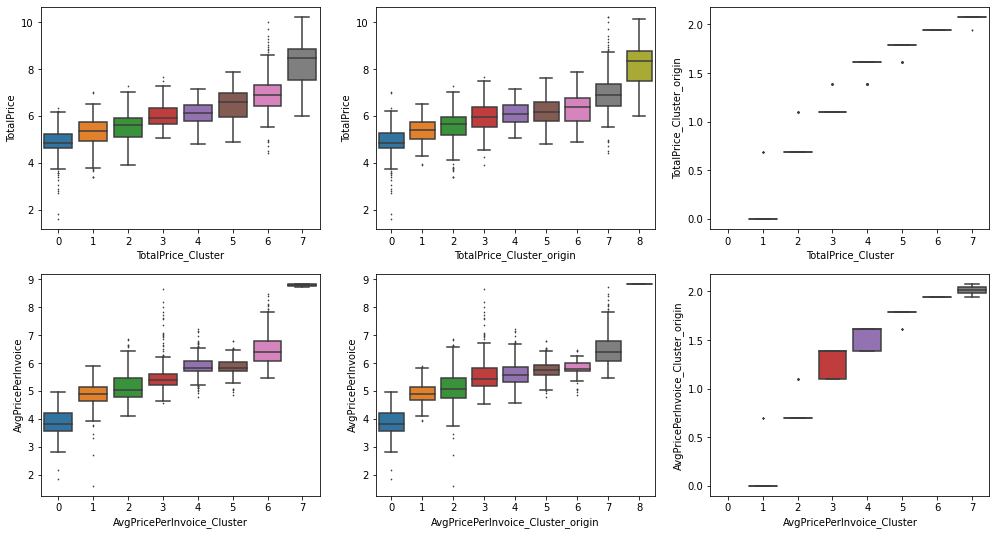

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


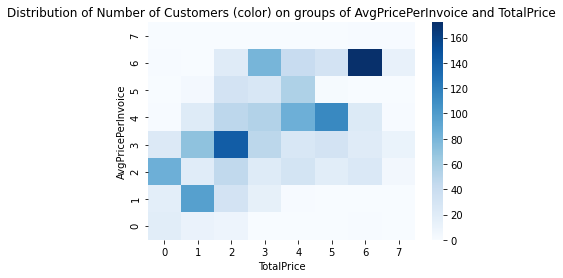

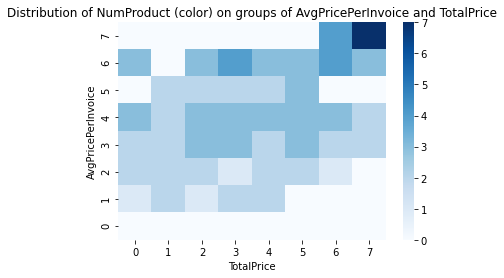

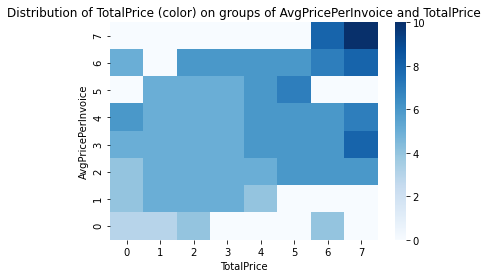

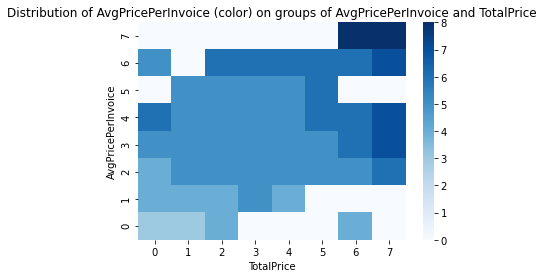

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

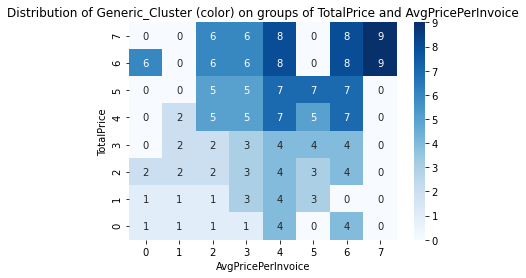

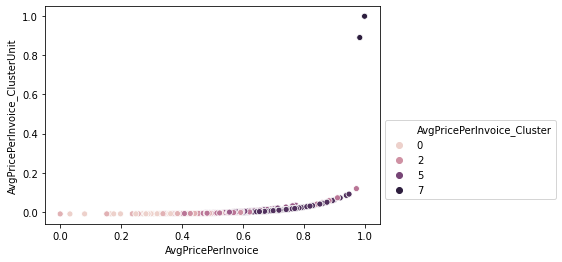

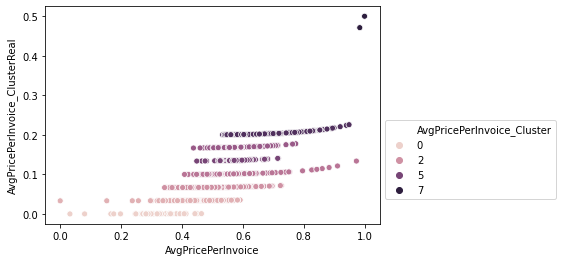

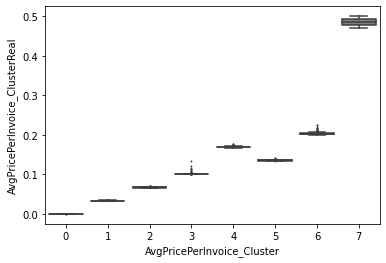

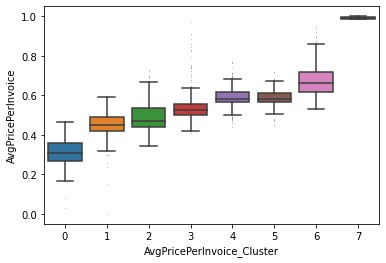

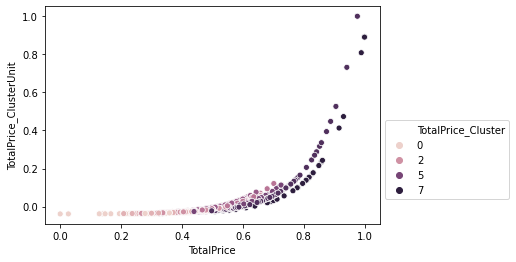

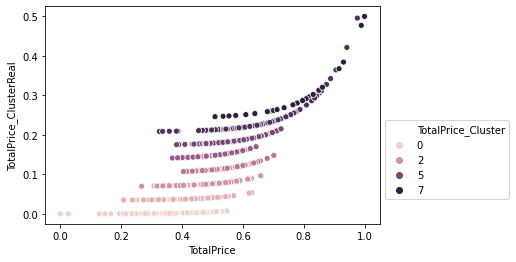

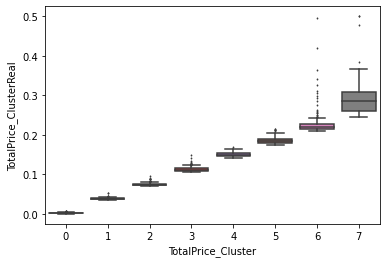

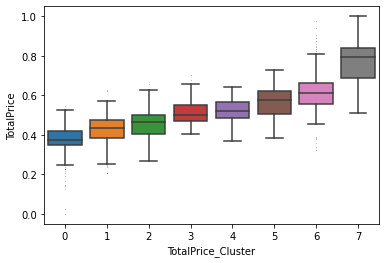

In [ ]:
z_func = lambda x, y: pd.Series(np.array(x*0.8+y*0.2).astype(int)) #origin + new
test_hybrid(cluster_df)

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                    22.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                   149.0  0.0  0.0  0.590604  0.0  1.0  3.0
2                   415.0  0.0  1.0  1.650602  2.0  2.0  6.0
3                   474.0  0.0  3.0  3.407173  3.0  5.0  7.0
4                   371.0  0.0  5.0  5.447439  5.0  7.0  8.0
5                   195.0  5.0  6.0  6.456410  7.0  7.0  8.0
6                    35.0  7.0  7.0  7.457143  7.0  8.0  8.0
7                     3.0  7.0  7.0  7.333333  7.0  7.5  8.0
                            count  min   25%      mean  50%   75%  max
AvgPricePerInvoice_Cluster                                            
0                            29.0  0.0  0.00  0.068966  0.0  0.00  2.0
1                           104.0  0.0  1.00  0.942308  1.0  1.00  2.0
2                           290.0  1.0  2.00  2.017241  2.0  2.00  6.0
3                           502.0  

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


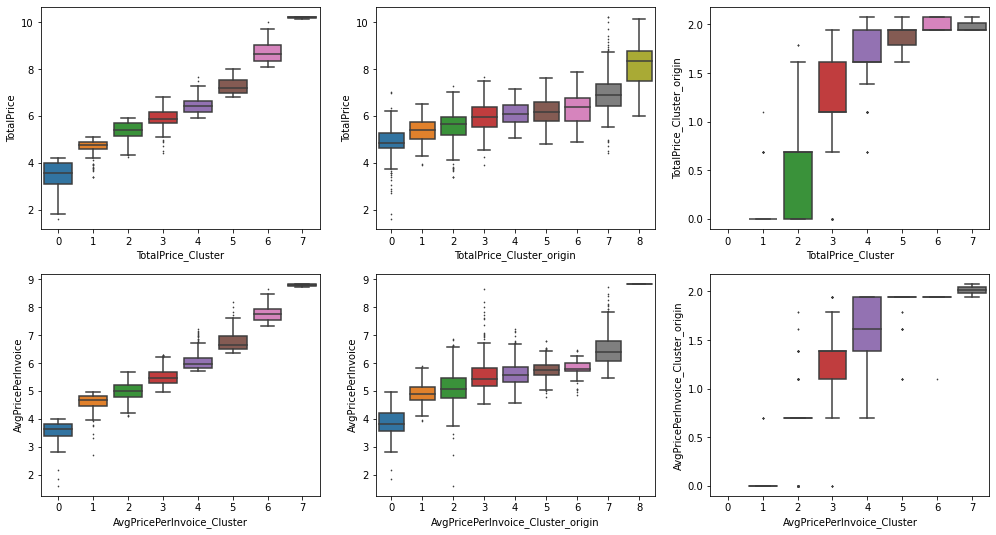

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


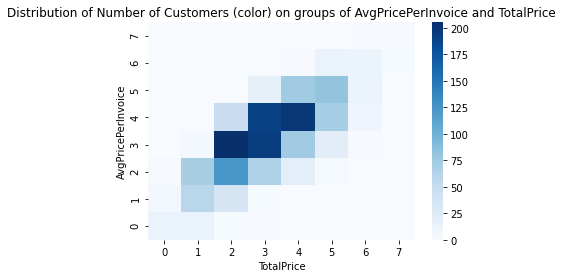

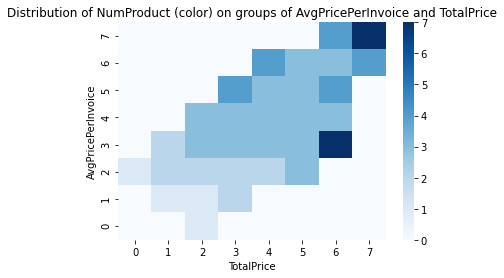

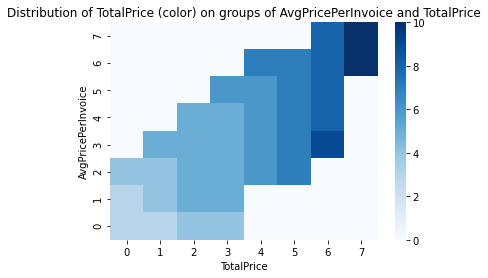

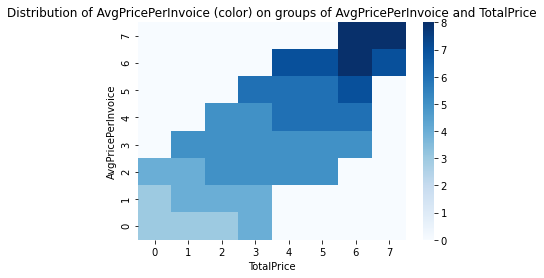

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

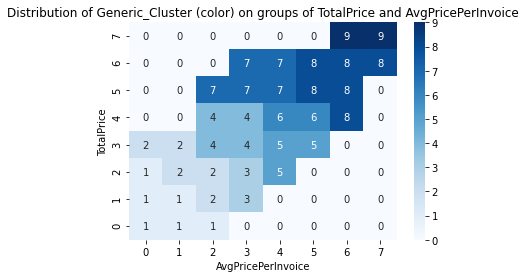

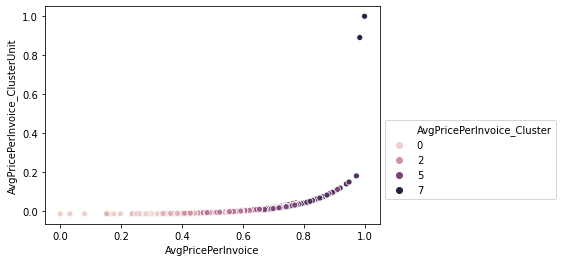

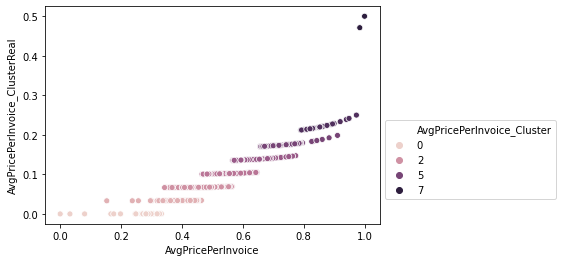

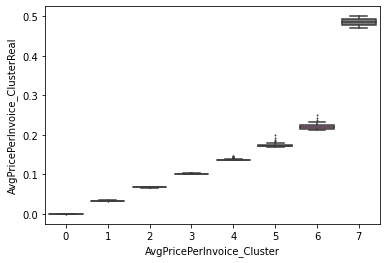

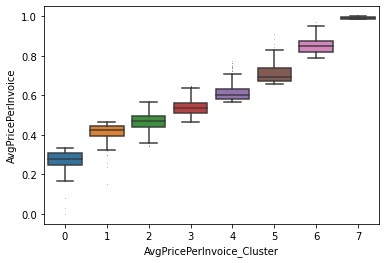

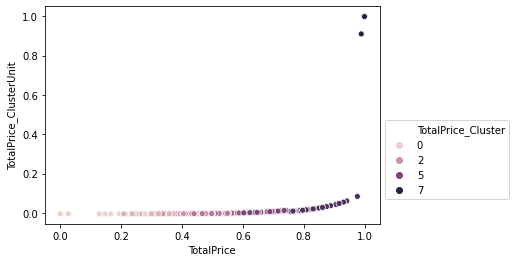

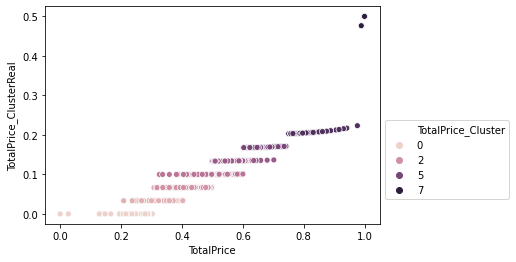

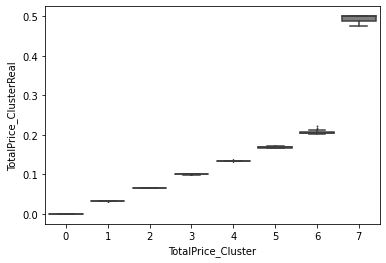

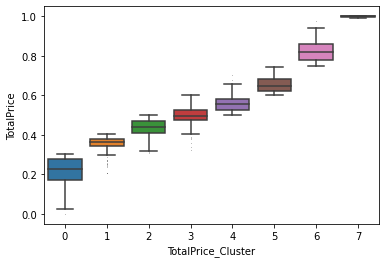

In [ ]:
z_func = lambda x, y: pd.Series(np.array(x*0.2+y*0.8).astype(int)) #origin + new
test_hybrid(cluster_df)

### Validate the hybrid with new regressor

In [ ]:
newregressor_cluster_df = pd.read_csv('segment/exp_save/2021_02_09_cluster_df.csv')
newregressor_cluster_df['CustomerID'] = np.array(newregressor_cluster_df['CustomerID']).astype(int)
newregressor_cluster_df = newregressor_cluster_df.merge(df[['CustomerID'] + all_target_name], on = ['CustomerID'], how = 'left')
newregressor_cluster_df.head()

CustomerID  AvgPricePerInvoice_Cluster  TotalPrice_Cluster  \
0       17733                           8                   8   
1       17419                           7                   8   
2       13461                           8                   8   
3       13697                           8                   8   
4       14911                           6                   7   

   Generic_Cluster  NumProduct  TotalPrice  AvgPricePerInvoice  
0                8          23      475.24          475.240000  
1                5          53     1101.02          367.006667  
2                8          10      560.80          560.800000  
3                8          12      151.30          151.300000  
4                4         918    22720.73          668.256765

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


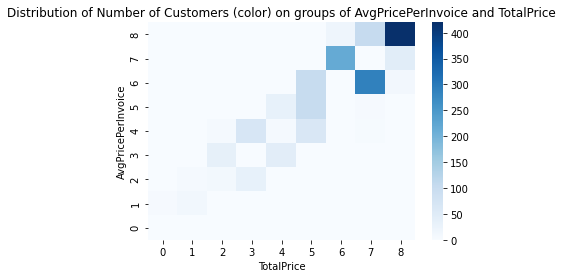

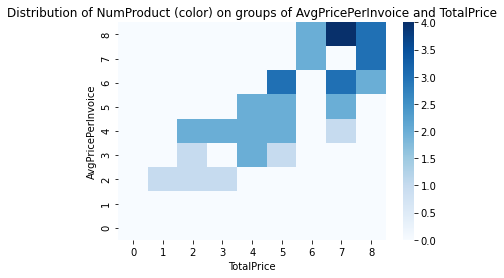

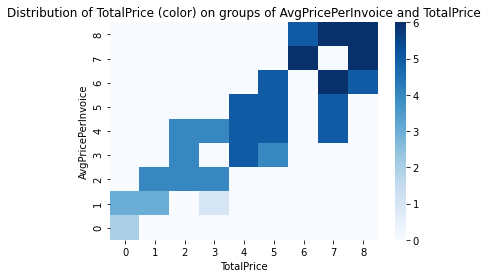

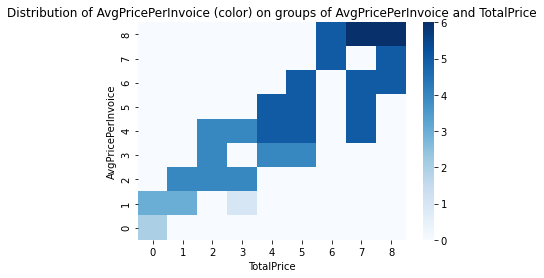

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

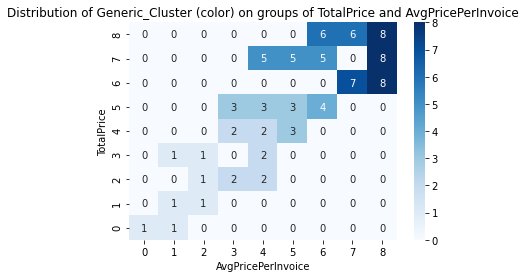

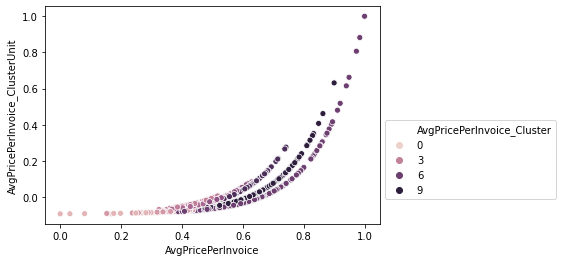

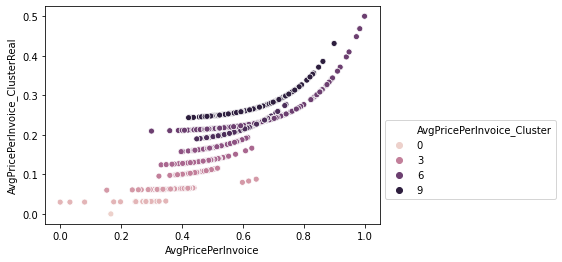

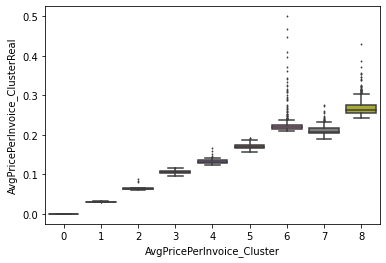

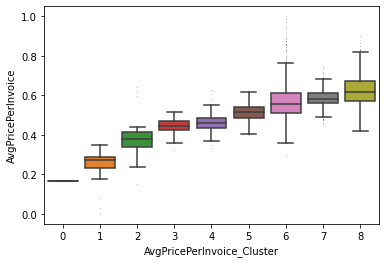

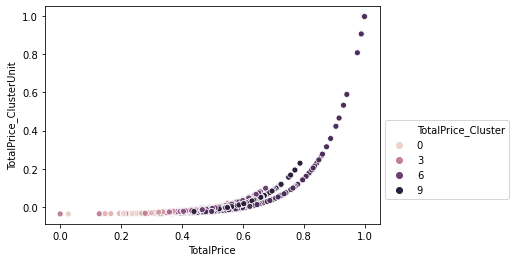

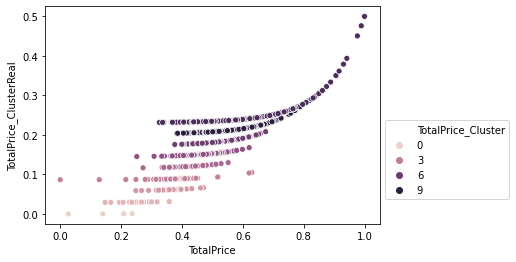

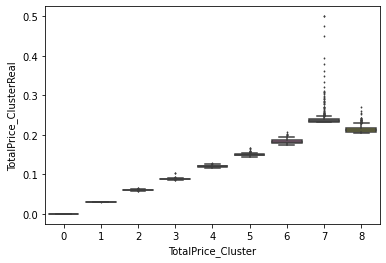

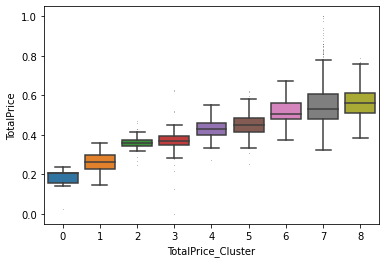

In [ ]:
_tmp_visualize_clusters(newregressor_cluster_df, cusseg_target)

In [ ]:
newregressor_cluster_df[['TotalPrice_Group', 'AvgPricePerInvoice_Group']] = get_groupdata(newregressor_cluster_df, ['TotalPrice', 'AvgPricePerInvoice'], percentiles = [0.02, 0.15, 0.5, 0.85, 0.95])
newregressor_cluster_df.head()

CustomerID  AvgPricePerInvoice_Cluster  TotalPrice_Cluster  \
0       17733                           8                   8   
1       17419                           7                   8   
2       13461                           8                   8   
3       13697                           8                   8   
4       14911                           6                   7   

   Generic_Cluster  NumProduct  TotalPrice  AvgPricePerInvoice  \
0                8          23      475.24          475.240000   
1                5          53     1101.02          367.006667   
2                8          10      560.80          560.800000   
3                8          12      151.30          151.300000   
4                4         918    22720.73          668.256765   

   TotalPrice_Group  AvgPricePerInvoice_Group  
0                 3                         3  
1                 4                         3  
2                 3                         3  
3                 1                         2  
4                 5                         4

In [ ]:
newregressor_cluster_df[['TotalPrice_Group', 'AvgPricePerInvoice_Group']] = get_groupdata(newregressor_cluster_df, ['TotalPrice', 'AvgPricePerInvoice'], percentiles = [0.02, 0.15, 0.5, 0.85, 0.95])
newregressor_cluster_df.head()

CustomerID  AvgPricePerInvoice_Cluster  TotalPrice_Cluster  \
0       17733                           8                   8   
1       17419                           7                   8   
2       13461                           8                   8   
3       13697                           8                   8   
4       14911                           6                   7   

   Generic_Cluster  NumProduct  TotalPrice  AvgPricePerInvoice  \
0                8          23      475.24          475.240000   
1                5          53     1101.02          367.006667   
2                8          10      560.80          560.800000   
3                8          12      151.30          151.300000   
4                4         918    22720.73          668.256765   

   TotalPrice_Group  AvgPricePerInvoice_Group  
0                 3                         3  
1                 4                         3  
2                 3                         3  
3                 1                         2  
4                 5                         4

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                     6.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                    22.0  0.0  0.0  0.318182  0.0  1.0  1.0
2                    55.0  0.0  1.0  1.036364  1.0  1.0  2.0
3                   103.0  0.0  1.0  1.174757  1.0  1.0  4.0
4                    87.0  0.0  1.0  1.758621  2.0  2.0  3.0
5                   271.0  0.0  2.0  2.022140  2.0  2.0  4.0
6                   237.0  1.0  2.0  2.599156  3.0  3.0  4.0
7                   405.0  1.0  2.0  3.024691  3.0  3.0  5.0
8                   478.0  1.0  3.0  3.102510  3.0  4.0  5.0
                            count  min  25%      mean  50%  75%  max
AvgPricePerInvoice_Cluster                                          
0                             1.0  0.0  0.0  0.000000  0.0  0.0  0.0
1                            20.0  0.0  0.0  0.050000  0.0  0.0  1.0
2                            53.0  0.0  1.0  0.886792

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/root/.local/share/virtualenvs/ds-CSRLTX

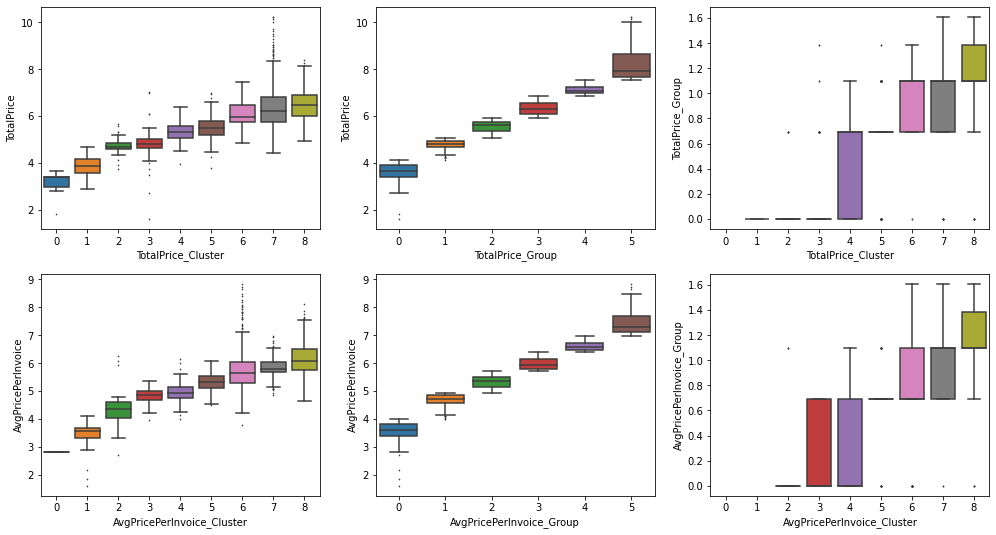

In [ ]:
_compare_clusterways(newregressor_cluster_df, name2='Group',name1='Cluster')

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                    21.0  0.0  0.0  0.714286  1.0  1.0  1.0
1                    65.0  1.0  2.0  2.015385  2.0  2.0  3.0
2                   121.0  2.0  3.0  3.173554  3.0  3.0  5.0
3                   292.0  3.0  5.0  4.763699  5.0  5.0  6.0
4                   409.0  5.0  6.0  6.246944  6.0  7.0  8.0
5                   568.0  6.0  7.0  7.570423  8.0  8.0  8.0
6                   188.0  7.0  7.0  7.707447  8.0  8.0  8.0
                            count  min  25%      mean  50%  75%  max
AvgPricePerInvoice_Cluster                                          
0                            20.0  0.0  1.0  0.950000  1.0  1.0  1.0
1                            52.0  1.0  2.0  2.000000  2.0  2.0  3.0
2                           162.0  2.0  3.0  3.456790  3.0  4.0  4.0
3                           222.0  4.0  4.0  4.779279  5.0  5.0  6.0
4                           412.0  5.

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


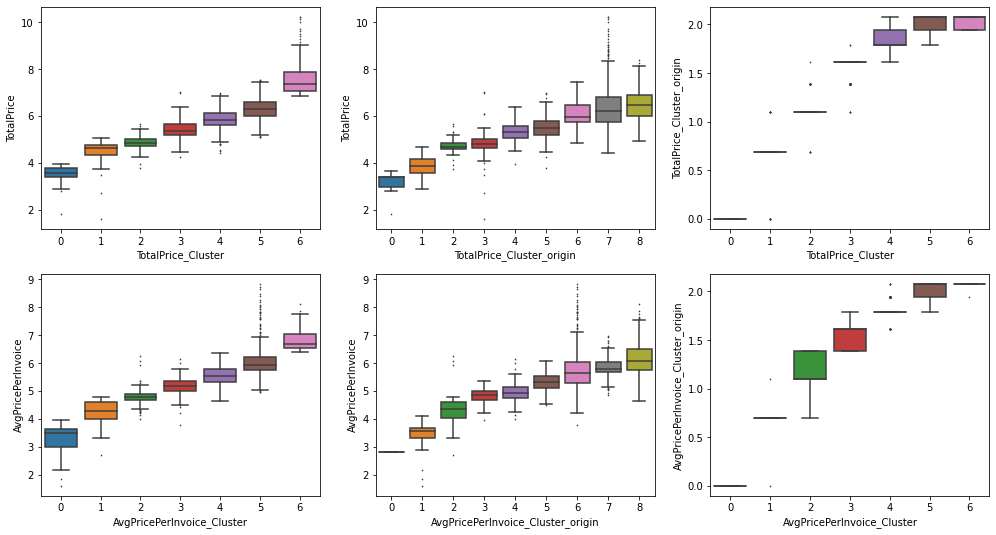

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


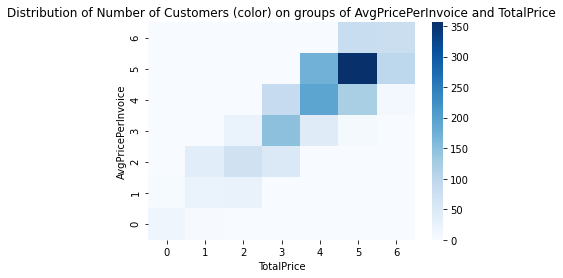

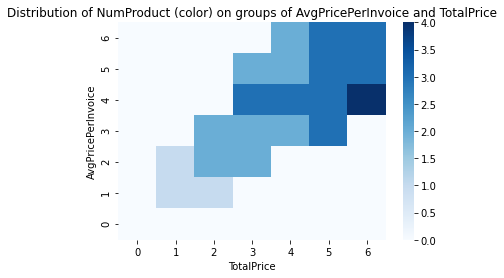

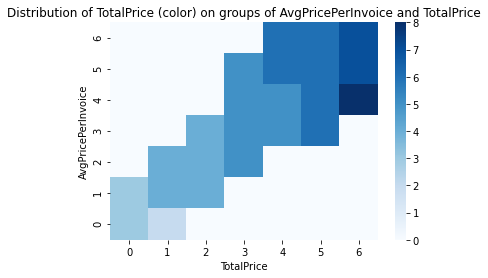

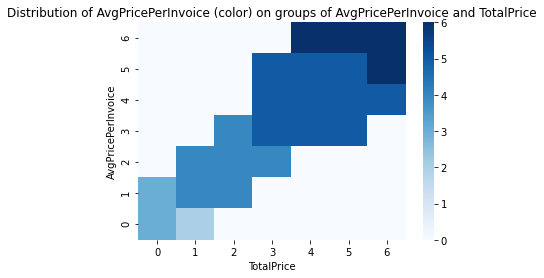

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

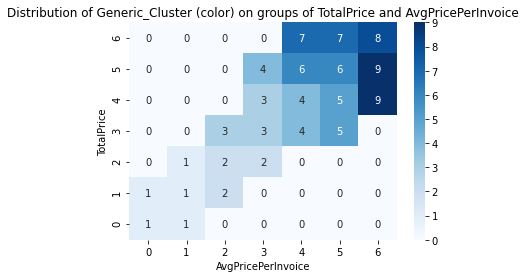

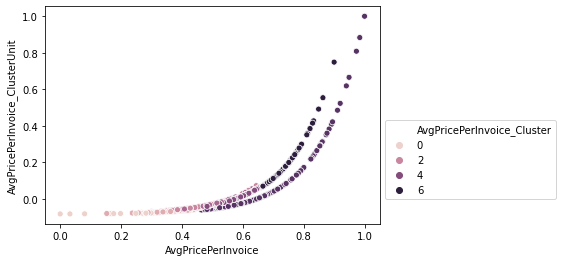

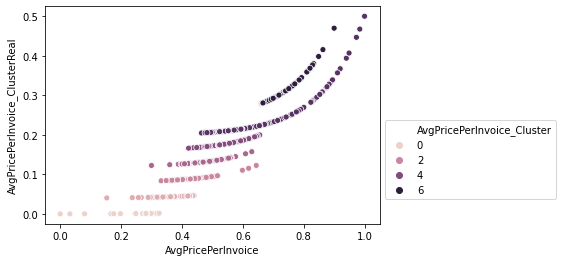

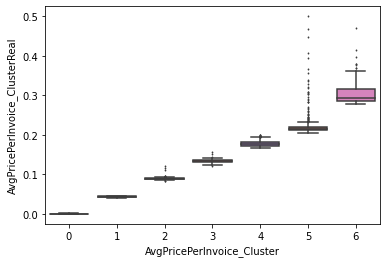

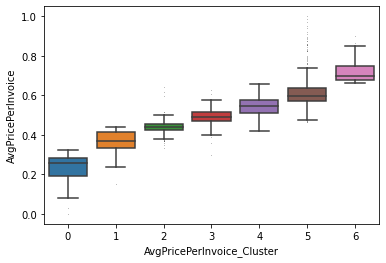

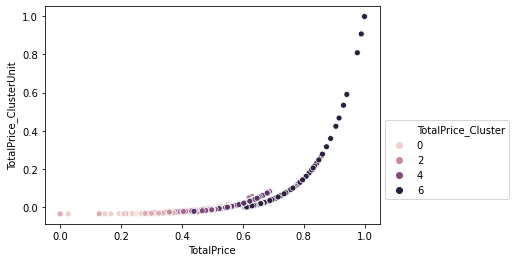

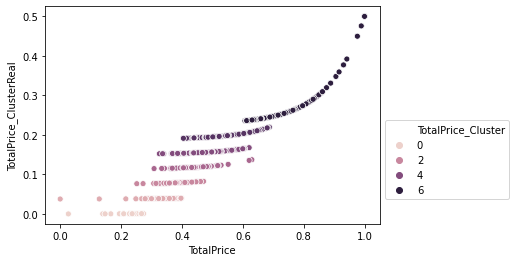

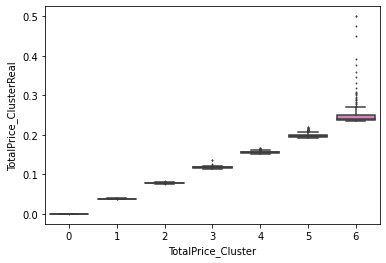

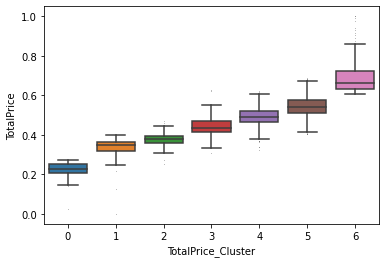

In [ ]:
z_func = lambda x, y: pd.Series(np.array(x*0.5+y*0.5).astype(int)) #origin + new
test_hybrid(newregressor_cluster_df)

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                    21.0  0.0  0.0  0.714286  1.0  1.0  1.0
1                    57.0  1.0  2.0  1.877193  2.0  2.0  2.0
2                   104.0  2.0  3.0  2.951923  3.0  3.0  3.0
3                    91.0  3.0  4.0  3.956044  4.0  4.0  4.0
4                   271.0  5.0  5.0  5.000000  5.0  5.0  5.0
5                   250.0  6.0  6.0  6.052000  6.0  6.0  7.0
6                   497.0  7.0  7.0  7.211268  7.0  7.0  8.0
7                   373.0  8.0  8.0  8.000000  8.0  8.0  8.0
                            count  min  25%      mean  50%  75%  max
AvgPricePerInvoice_Cluster                                          
0                            20.0  0.0  1.0  0.950000  1.0  1.0  1.0
1                            51.0  1.0  2.0  1.980392  2.0  2.0  2.0
2                            86.0  2.0  3.0  2.965116  3.0  3.0  3.0
3                           152.0  4.0  4.0  

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


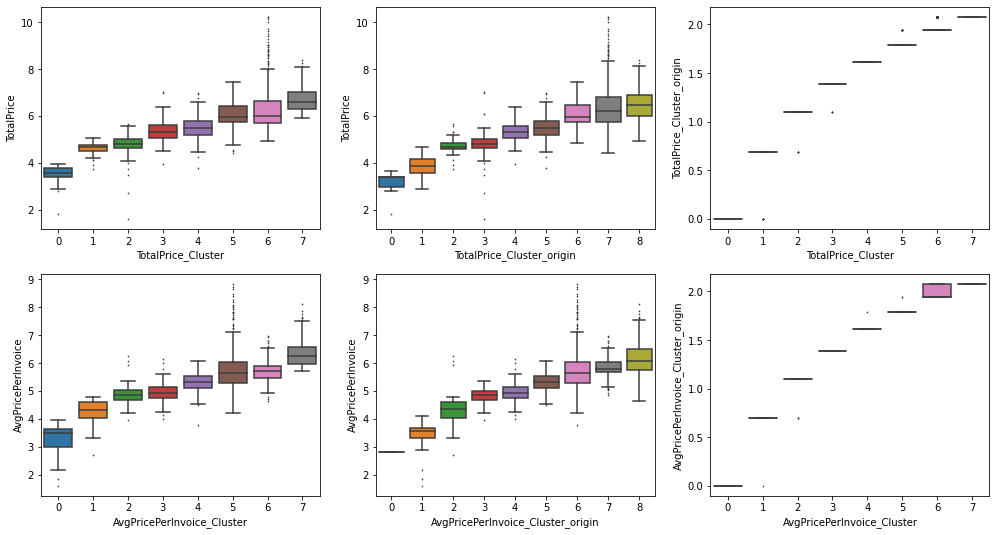

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


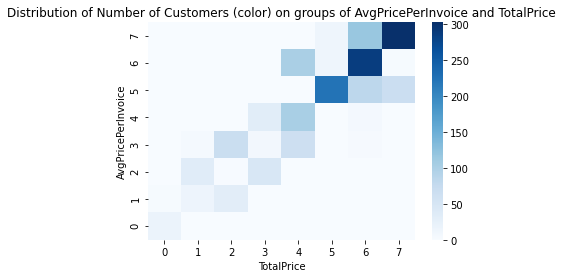

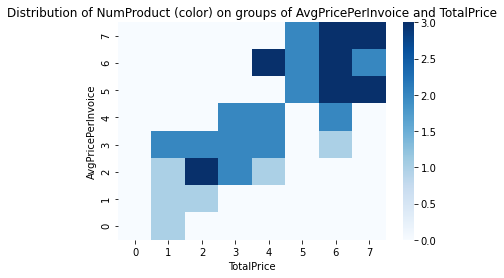

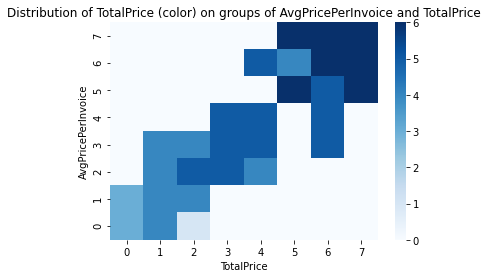

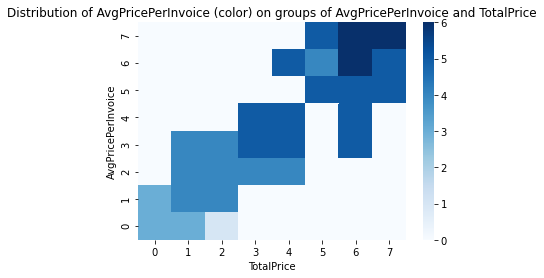

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

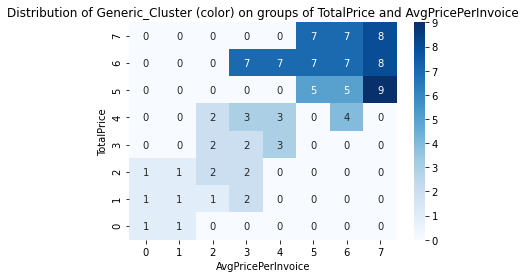

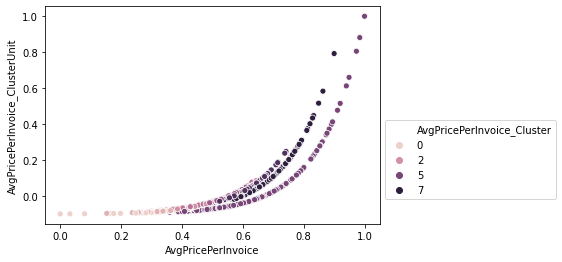

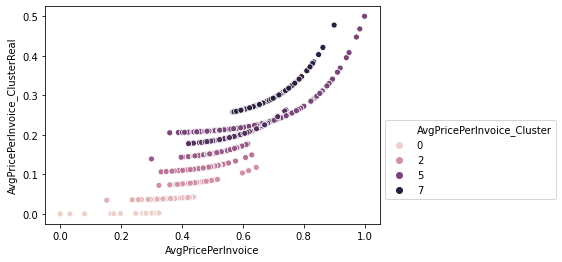

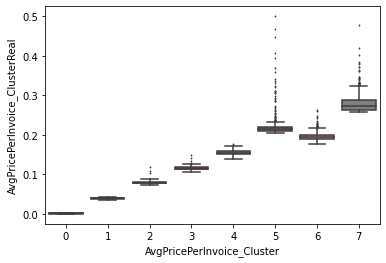

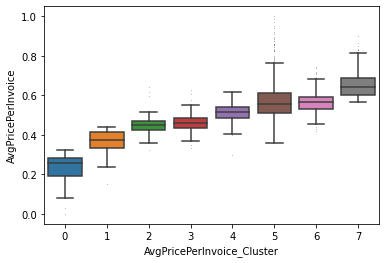

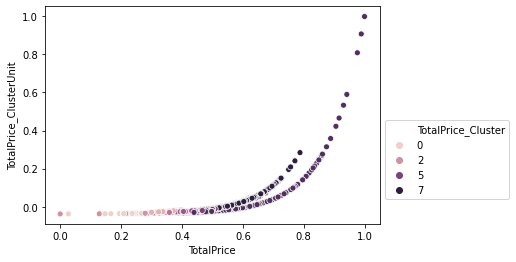

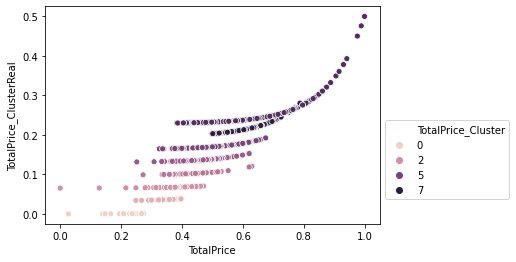

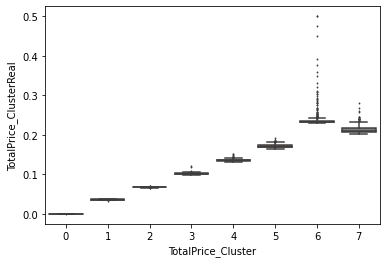

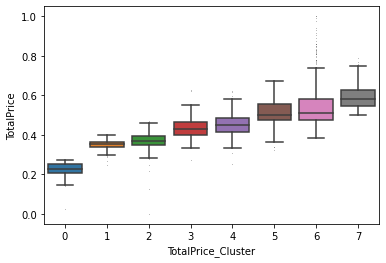

In [ ]:
z_func = lambda x, y: pd.Series(np.array(x*0.8+y*0.2).astype(int)) #origin + new
test_hybrid(newregressor_cluster_df)

                    count  min  25%      mean  50%  75%  max
TotalPrice_Cluster                                          
0                    33.0  0.0  1.0  1.484848  1.0  3.0  4.0
1                   194.0  1.0  2.0  3.237113  3.0  4.0  5.0
2                   389.0  2.0  5.0  5.128535  5.0  6.0  8.0
3                   560.0  3.0  6.0  6.751786  7.0  7.0  8.0
4                   404.0  5.0  8.0  7.809406  8.0  8.0  8.0
5                    84.0  7.0  7.0  7.345238  7.0  8.0  8.0
                            count  min  25%      mean  50%  75%  max
AvgPricePerInvoice_Cluster                                          
0                            33.0  0.0  1.0  1.393939  1.0  2.0  3.0
1                           186.0  1.0  3.0  3.376344  3.5  4.0  6.0
2                           436.0  2.0  5.0  5.229358  6.0  6.0  8.0
3                           493.0  4.0  6.0  6.878296  7.0  7.0  8.0
4                           432.0  6.0  8.0  7.821759  8.0  8.0  8.0
5                            

/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/.local/share/virtualenvs/ds-CSRLTXzN/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


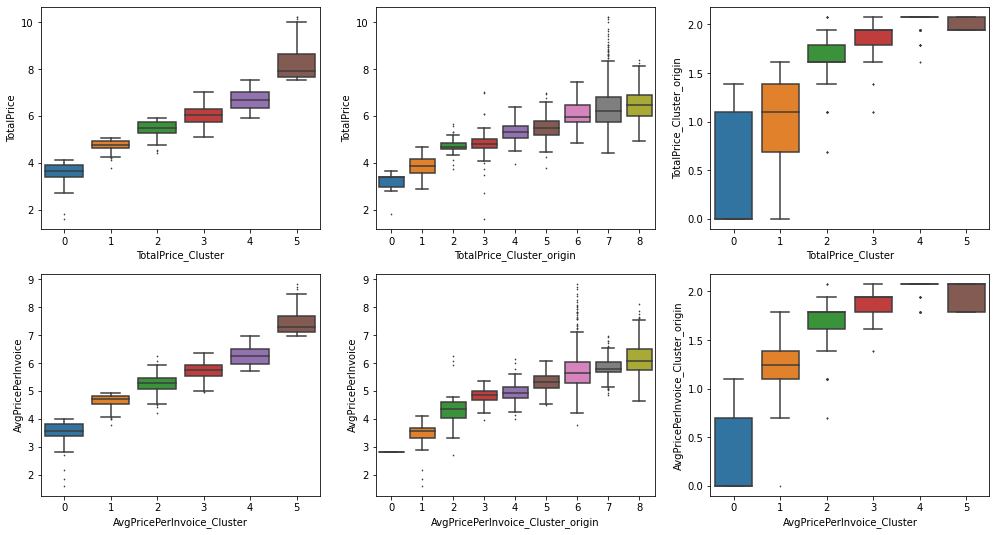

('AvgPricePerInvoice', 'TotalPrice')


/src/exp/ds/segment/Generic_Segment/Segment_Analytics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['%s_Cluster'%target] = all_clusters['%s'%target]


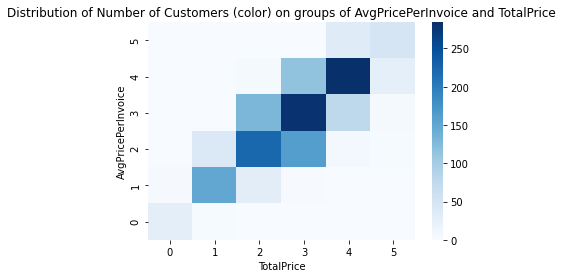

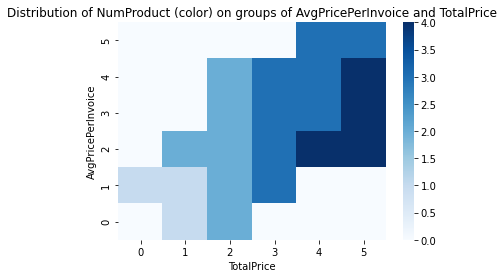

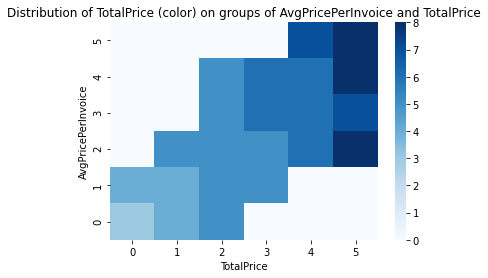

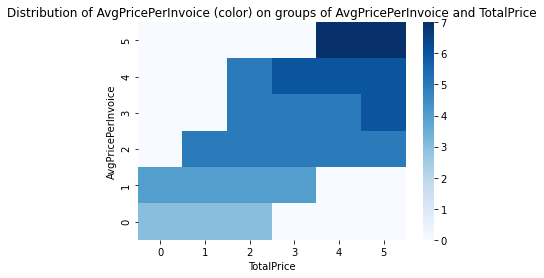

/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values[kpi_name] = scale_minmax(np.log(cluster_values[kpi_name]))
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_values['%s_ClusterUnit' % kpi_name] = scale_signunit(clustervalue_range)
/src/exp/ds/segment/Generic_Segment/Generic_Segment.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

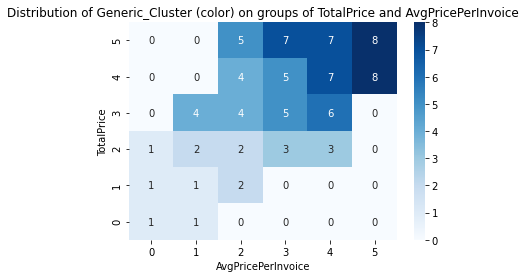

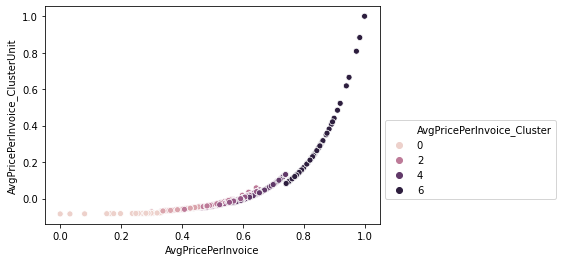

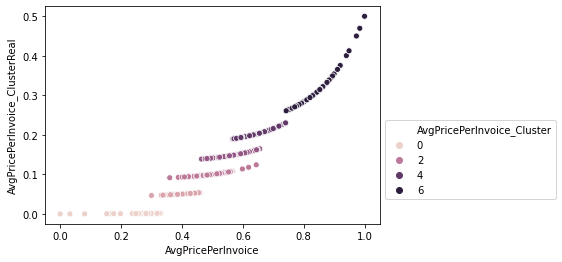

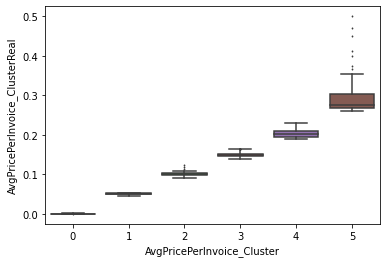

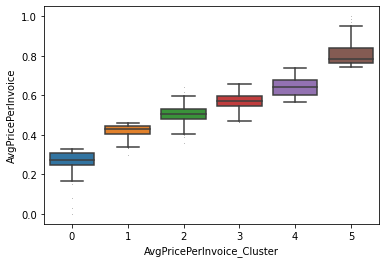

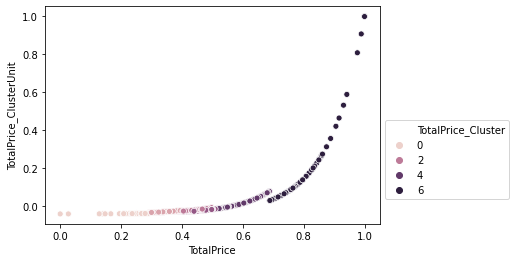

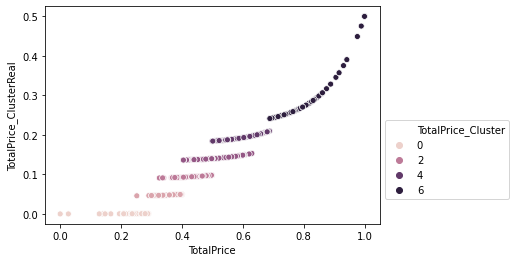

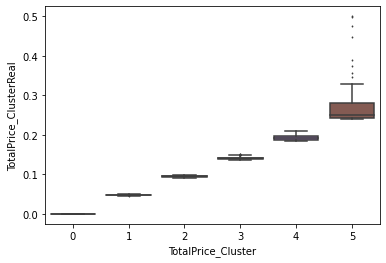

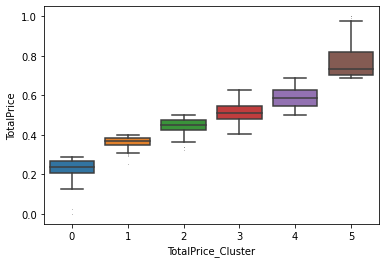

In [ ]:
z_func = lambda x, y: pd.Series(np.array(x*0.2+y*0.8).astype(int)) #origin + new
test_hybrid(newregressor_cluster_df)

## Results of the hybrid in 2 regressors

In [ ]:
# cluster_df[['CustomerID', 'TotalPrice_Group', 'AvgPricePerInvoice_Group', 'TotalPrice', 'AvgPricePerInvoice', 'NumProduct']].to_csv('segment/exp_save/traindata.csv', index=False)

# Draft

In [ ]:
target_name = 'TotalPrice'
mapping_df = cluster_df.groupby(['%s_Cluster'%target_name])['%s_Group'%target_name].describe(percentiles = [0.25, 0.5, 0.75])['50%'].reset_index()
mapping_clusters = dict(zip(mapping_df['%s_Cluster'%target_name], np.array(mapping_df['50%']).astype(int)))
mapping_clusters

{0: 2, 1: 3, 2: 3, 3: 4, 4: 4, 5: 4, 6: 4, 7: 5, 8: 6}

In [ ]:
cluster_df['TotalPrice_Cluster_2'] = list(map(lambda x: mapping_clusters[x], cluster_df['TotalPrice_Cluster']))
cluster_df.head()

CustomerID  AvgPricePerInvoice_Cluster  TotalPrice_Cluster  \
0       17733                           5                   6   
1       17419                           5                   5   
2       13461                           4                   6   
3       13697                           2                   5   
4       14911                           7                   7   

   Generic_Cluster  NumProduct  TotalPrice  AvgPricePerInvoice  \
0                6          23      475.24          475.240000   
1                6          53     1101.02          367.006667   
2                5          10      560.80          560.800000   
3                5          12      151.30          151.300000   
4                8         918    22720.73          668.256765   

   TotalPrice_Group  AvgPricePerInvoice_Group  TotalPrice_Cluster_2  
0                 4                         4                     4  
1                 5                         4                     4  
2                 4                         4                     4  
3                 2                         3                     4  
4                 6                         5                     5

In [ ]:
def agg_clusters(cluster_df, mapping_clusters, list_features_name, cusseg_target, origin_cluster='Generic_Cluster'):
    cluster_df['Agg_Cluster'] = list(map(lambda x: mapping_clusters[x], cluster_df[origin_cluster]))
    cluster_df['Agg_Cluster'] = cluster_df['Agg_Cluster'] + 1
    cluster_df[list_features_name + cusseg_target] = np.log(df[list_features_name + cusseg_target])
    from segment.visualize_segmentana import visualize_matrixcluster
    visualize_matrixcluster(cluster_df, 'Agg_Cluster', generic_group_define=None, func_group_name = "mean", func_sum = np.mean, histogram_vis=False, heatmap_annot=True)
    return cluster_df

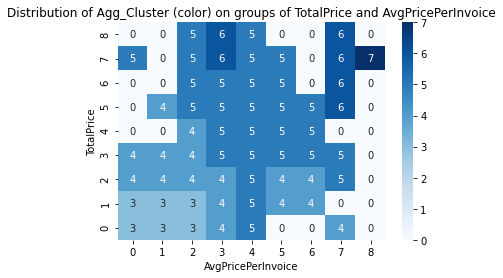

CustomerID  AvgPricePerInvoice_Cluster  TotalPrice_Cluster  \
0          17733                           5                   6   
1          17419                           5                   5   
2          13461                           4                   6   
3          13697                           2                   5   
4          14911                           7                   7   
...          ...                         ...                 ...   
1659       16915                           2                   0   
1660       16265                           7                   7   
1661       14085                           5                   4   
1662       12429                           7                   6   
1663       15444                           7                   7   

      Generic_Cluster  NumProduct  TotalPrice  AvgPricePerInvoice  \
0                   6          23    6.163820            6.163820   
1                   6          53    7.003992            5.905380   
2                   5          10    6.329364            6.329364   
3                   5          12    5.019265            5.019265   
4                   8         918   10.031033            6.504672   
...               ...         ...         ...                 ...   
1659                0           8    4.697567            4.697567   
1660                7          33    6.671906            6.671906   
1661                6          17    5.630566            5.630566   
1662                7          27    6.808509            6.808509   
1663                7         147    6.980411            6.980411   

      TotalPrice_Group  AvgPricePerInvoice_Group  TotalPrice_Cluster_2  \
0                    4                         4                     4   
1                    5                         4                     4   
2                    4                         4                     4   
3                    2                         3                     4   
4                    6                         5                     5   
...                ...                       ...                   ...   
1659                 2                         2                     2   
1660                 4                         5                     5   
1661                 3                         3                     4   
1662                 5                         5                     4   
1663                 5                         5                     5   

      Agg_Cluster  AvgUnitPrice  SumQuantity  AvgQuantityPerInvoice  \
0               5      0.654813     5.929589               5.929589   
1               5      1.306904     6.025866               4.927254   
2               5      0.599386     5.811141               5.811141   
3               5      0.331699     5.176150               5.176150   
4               7      1.405282     9.430439               5.904079   
...           ...           ...          ...                    ...   
1659            3      1.491217     3.737670               3.737670   
1660            6      0.891253     6.118097               6.118097   
1661            5      0.575621     5.476464               5.476464   
1662            6      0.601276     6.238325               6.238325   
1663            6      1.121234     6.349139               6.349139   

      AvgQuantityPerProduct  AvgProductPerInvoice  
0                  2.794095              3.135494  
1                  2.055574              2.871680  
2                  3.508556              2.302585  
3                  2.691243              2.484907  
4                  2.608242              3.295837  
...                     ...                   ...  
1659               1.658228              2.079442  
1660               2.621590              3.496508  
1661               2.643250              2.833213  
1662               2.942488              3.295837  
1663               1.358706              4.990

In [ ]:
agg_clusters(cluster_df, mapping_clusters, list_features_name, cusseg_target, origin_cluster = 'Generic_Cluster')